# Initialisations

In [3]:
library(ggplot2)
library(corrplot)
library(cluster)
library(reshape2)
theme_set(theme_classic())

corrplot 0.84 loaded


# Plot Functions

In [4]:
adenome_boxplot <- function(df, feature_index, title){
  x_axis = colnames(df)[feature_index]
  caption = "Source : ADENOME-PROS"

  g <- ggplot(df, aes("", df[,feature_index]))
  g <- g + geom_boxplot(varwidth=T, fill="plum")
  g <- g + labs(title=title, 
         subtitle=x_axis,
         caption=caption,
         x=x_axis,
         y="")
  print(g)
}

adenome_boxplot_couple <- function(df, feature_1, feature_2, f1, f2){
  x_axis = f1
  y_axis = f2
  title = paste(x_axis, " Vs. ", y_axis)
  caption = "Source : ADENOME-PROS"
    
  g <- ggplot(df, aes(x = feature_1, y = feature_2))
  g <- g + geom_boxplot(varwidth=T, fill="plum")
  g <- g + labs(title=title, 
         subtitle="",
         caption=caption,
         x=x_axis,
         y=y_axis)
    
  print(g)
}

adenome_scatterplot <- function(df, feature_1, feature_2, f1, f2) {
  x_axis = f1
  y_axis = f2
  title = paste(x_axis, " Vs. ", y_axis)
  caption = "Source : ADENOME-PROS"
  g <- ggplot(df, aes(x=feature_1, y=feature_2))
  g <- g + geom_point()
  g <- g + labs(title=title,y=y_axis,x=x_axis,caption=caption)
  print(g)
}

adenome_barplot <- function(df, feature_index, title) {
  caption = "Source : ADENOME-PROS"
  x_axis = colnames(df)[feature_index]
  g <- ggplot(df, aes(df[,feature_index]))
  g <- g + geom_bar(width = 0.5)
  g <- g + labs(title=title, 
         subtitle=x_axis,
         caption=caption,
         x=x_axis,
         y="")
  print(g)
}

adenome_piechart <- function(df, feature_index, title){
  bar <- ggplot(vapor, aes(x="", fill = factor(df[,feature_index]))) + geom_bar(width = 1)
  pie <- bar + coord_polar(theta = "y")
  print(pie)
}

# Obtenir le triangle inférieur d'une matrice
get_lower_tri <- function(mat){
    mat[upper.tri(mat)] <- NA
    return(mat)
}

# Obtenir le triangle supérieur d'une matrice
get_upper_tri <- function(mat){
    mat[lower.tri(mat)] <- NA
    return(mat)
}

# Re-ordonne la matrice de corrélation
reorder_cormat <- function(cormat){
    # Utiliser la corrélation entre les variables
    # comme mesure de distance
    dd <- as.dist((1-cormat)/2)
    hc <- hclust(dd)
    cormat <- cormat[hc$order, hc$order]
}

adenome_heatmap <- function(cormat) { 
    # Reordonner la matrice de corrélation
    cormat <- reorder_cormat(cormat)
    upper_tri <- get_upper_tri(cormat)
    # Fondre la matrice de corrélation
    melted_cormat <- melt(upper_tri, na.rm = TRUE)
    # Créer le heatmap
    ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
        geom_tile(color = "white")+
        scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
        midpoint = 0, limit = c(-1,1), space = "Lab",
        name="Pearson\nCorrelation") +
        theme_minimal()+ # minimal theme
        theme(axis.text.x = element_text(angle = 45, vjust = 1, 
        size = 12, hjust = 1))+
        coord_fixed()
    
ggheatmap <- ggheatmap + 
    geom_text(aes(Var2, Var1, label = round(value,3)), color = "black", size = 3) +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.grid.major = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank(),
      axis.ticks = element_blank(),
      legend.justification = c(1, 0),
      legend.position = c(0.6, 0.7),
      legend.direction = "horizontal")+
      guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                title.position = "top", title.hjust = 0.5))
    
    # Afficher heatmap
    print(ggheatmap)
}

# Cleanup & Data Preparation

# Pré-traitements

Les fichiers ont été transformés et nettoyés en CSV avant import dans R
La variable "résidu post mictionnel" comportant des valeurs nulles pour certains individus, nous avons mis des 0 à la place. Ces individus sont des individus qui sont porteurs de sonde et qui n'ont aucun résidu post-mictionnel.

# Préparation des datasets

In [5]:
# Chargement du dataset de base
vapor<-read.csv(file = "datasets/VAPOR.csv", sep = ",")

# Cast des variables booléennes
vapor$Comorbidite<-as.logical(vapor$Comorbidite)
vapor$Porteur_Sonde<-as.logical(vapor$Porteur_Sonde)
vapor$Transfusion<-as.logical(vapor$Transfusion)
vapor$Caillotage<-as.logical(vapor$Caillotage)
vapor$Reprise_Bloc<-as.logical(vapor$Reprise_Bloc)

# Cast des variables catégoriques
vapor$Indication<-as.factor(vapor$Indication)
vapor$Anesthesie<-as.factor(vapor$Anesthesie)
vapor$Evenement<-as.factor(vapor$Evenement)
vapor$Technique<-as.factor(vapor$Technique)

# Cast des variables catégoriques ordonnées
vapor$QoL<-as.ordered(vapor$QoL)
vapor$X1M_QoL<-as.ordered(vapor$X1M_QoL)
vapor$X3M_QoL<-as.ordered(vapor$X3M_QoL)
vapor$X6M_QoL<-as.ordered(vapor$X6M_QoL)
vapor$X9M_QoL<-as.ordered(vapor$X9M_QoL)
vapor$X12M_QoL<-as.ordered(vapor$X12M_QoL)
vapor$X15M_QoL<-as.ordered(vapor$X15M_QoL)
vapor$X18M_QoL<-as.ordered(vapor$X18M_QoL)

# 20 premières colonnes du dataset -> pré-opératoire, les dernières -> post-opératoire
vapor_pre<-vapor[,1:20]
vapor_post<-vapor[,21:41]

# On crée un dataframe ne comportant que les variables numériques (pour corrélation linéaire de Pearson)
vapor_num <- vapor[,sapply(vapor, function(x) is.numeric(x))]
vapor_num_pre = vapor_num[1:10]
vapor_num_post = vapor_num[11:24]

# On crée un dataframe ne comportant que les données booléennes, ordinales ou catégoriques
vapor_cat <- vapor[,sapply(vapor, function(x) is.ordered(x) | is.factor(x) | is.logical(x))]
vapor_cat = subset(vapor,select=c(Comorbidite,Porteur_Sonde,QoL,Indication,Anesthesie,Evenement,Technique,Transfusion,Caillotage,Reprise_Bloc,X1M_QoL,X3M_QoL,X6M_QoL,X9M_QoL,X12M_QoL,X15M_QoL,X18M_QoL))
vapor_cat_pre = vapor_cat[1:10]
vapor_cat_post = vapor_cat[11:17]

# 1. Analyse Descriptive
## 1.1 Pré-opératoire
### 1.1.1 Distributions

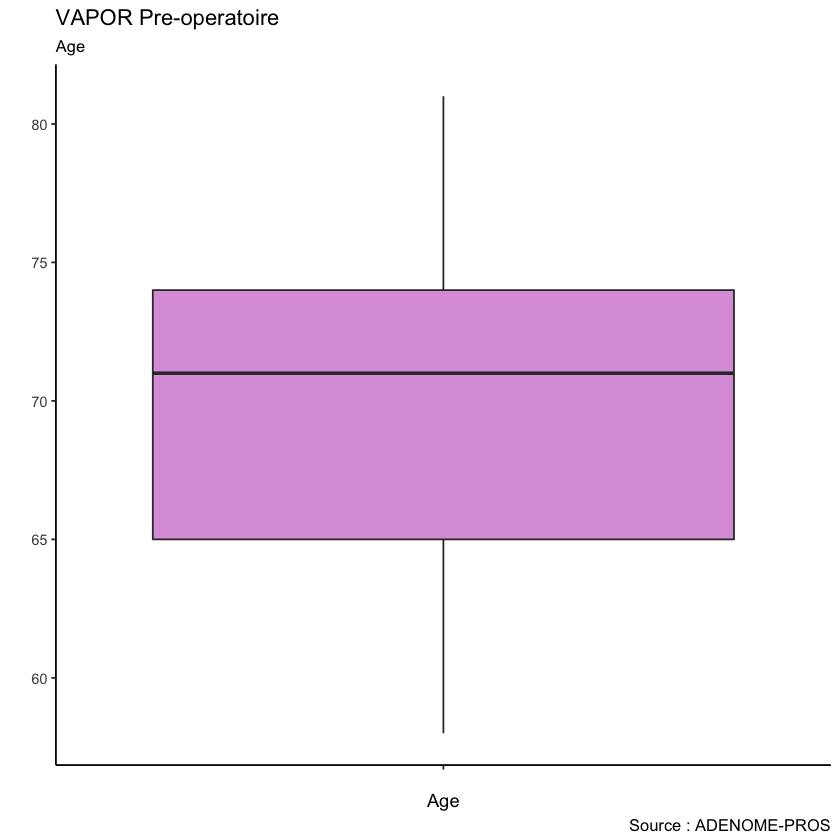

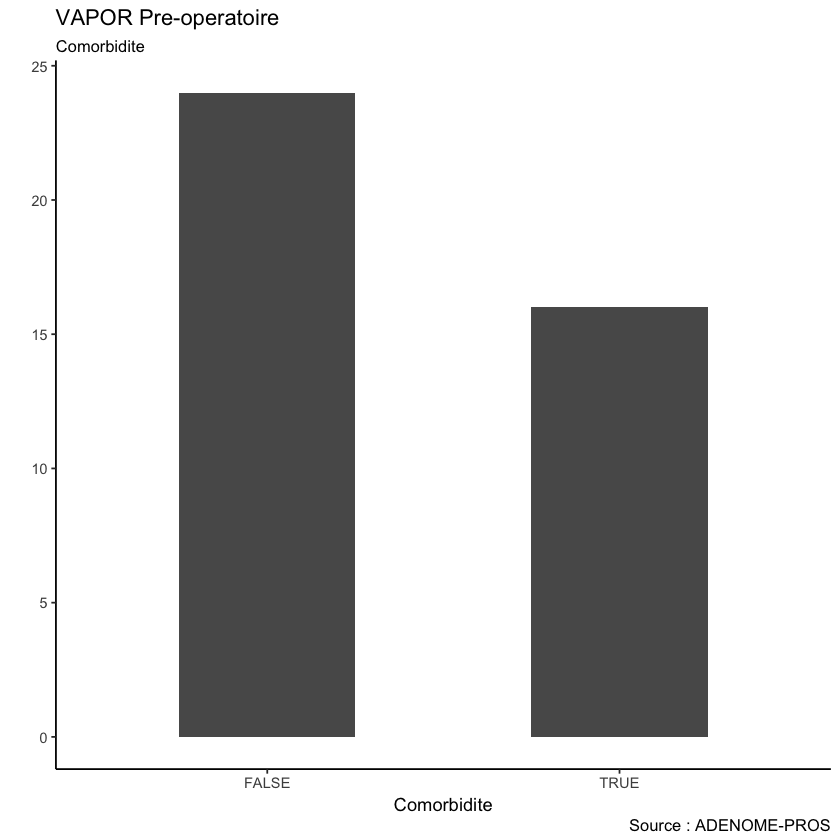

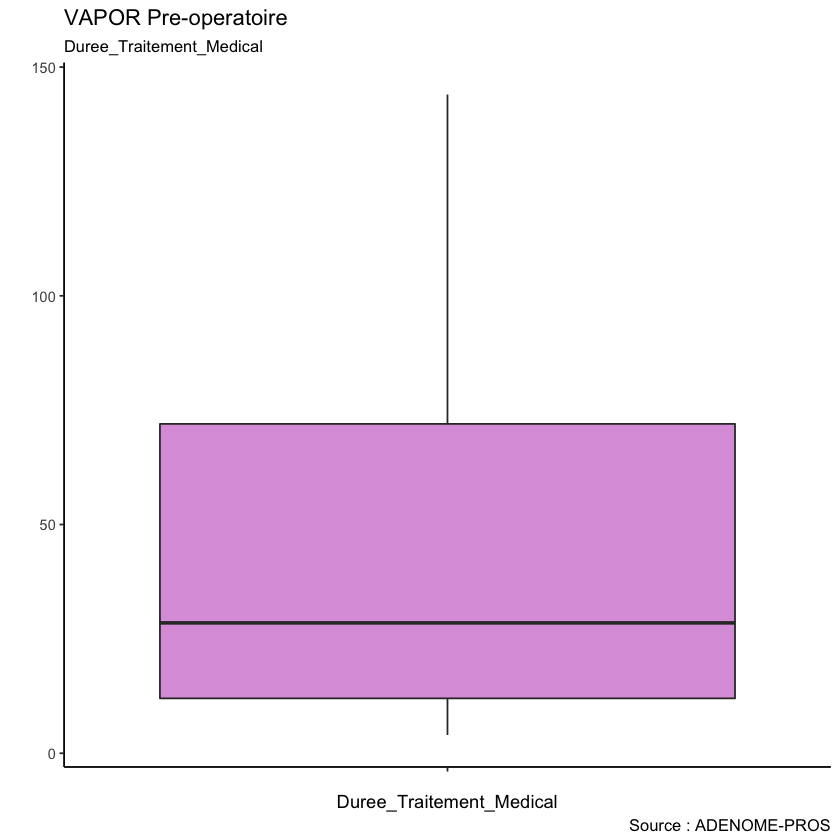

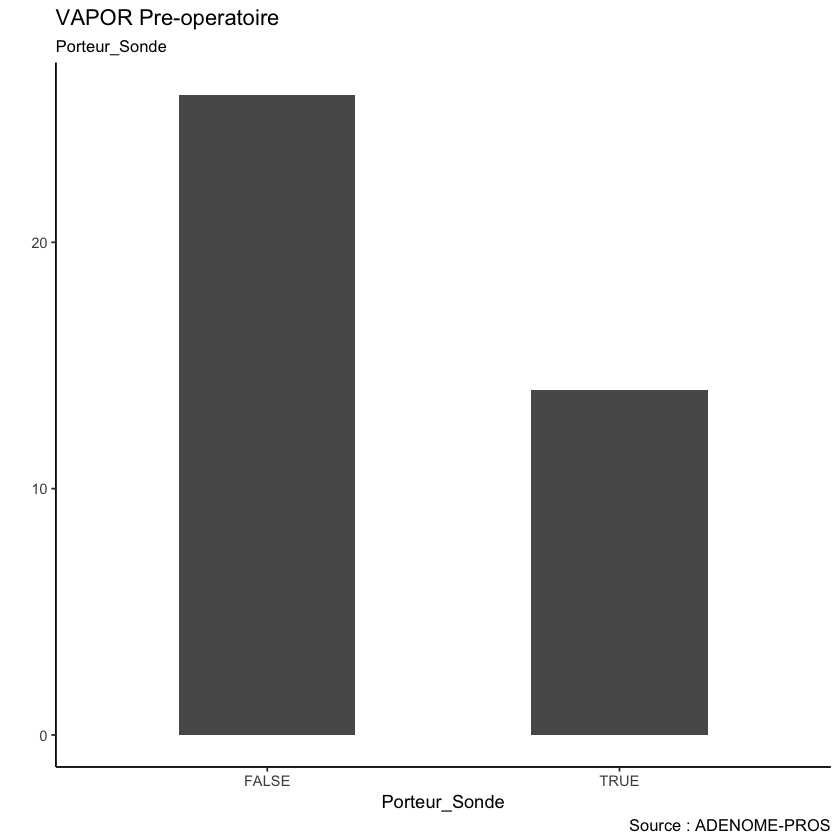

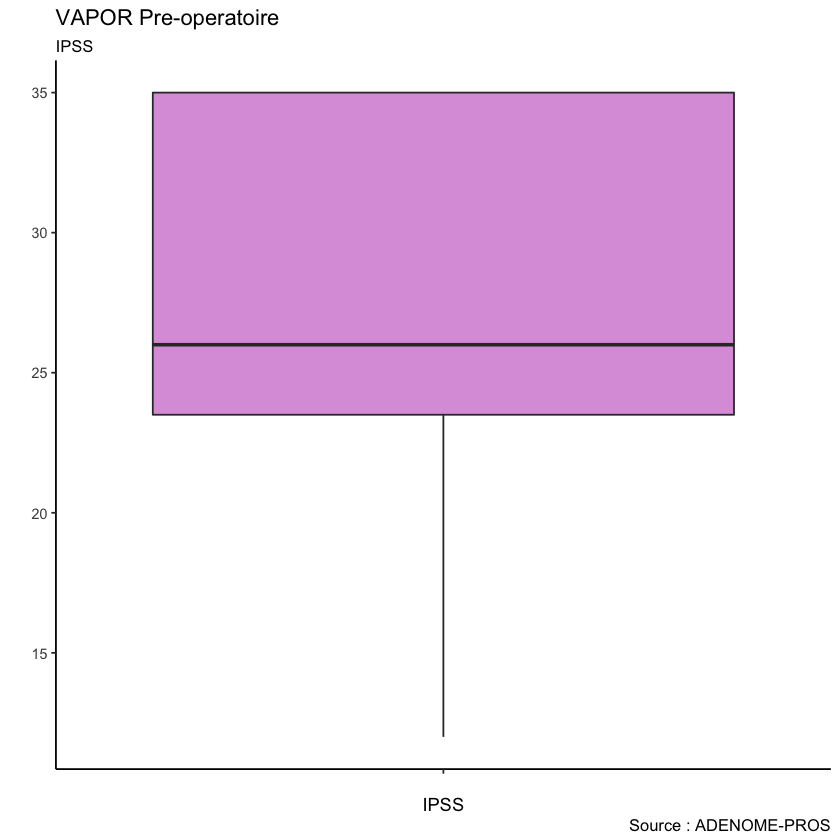

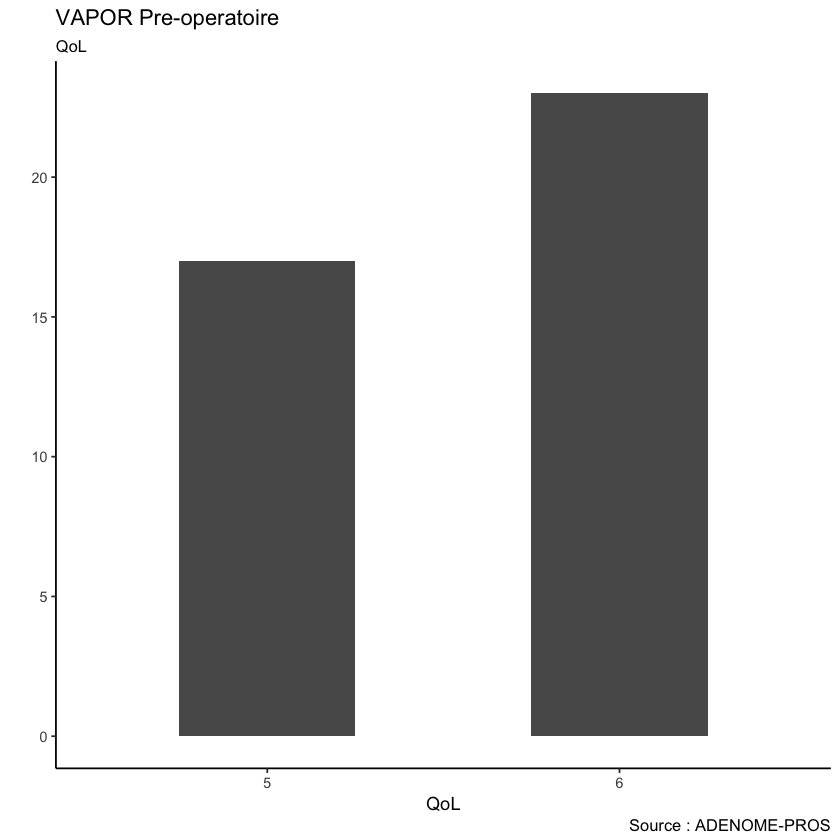

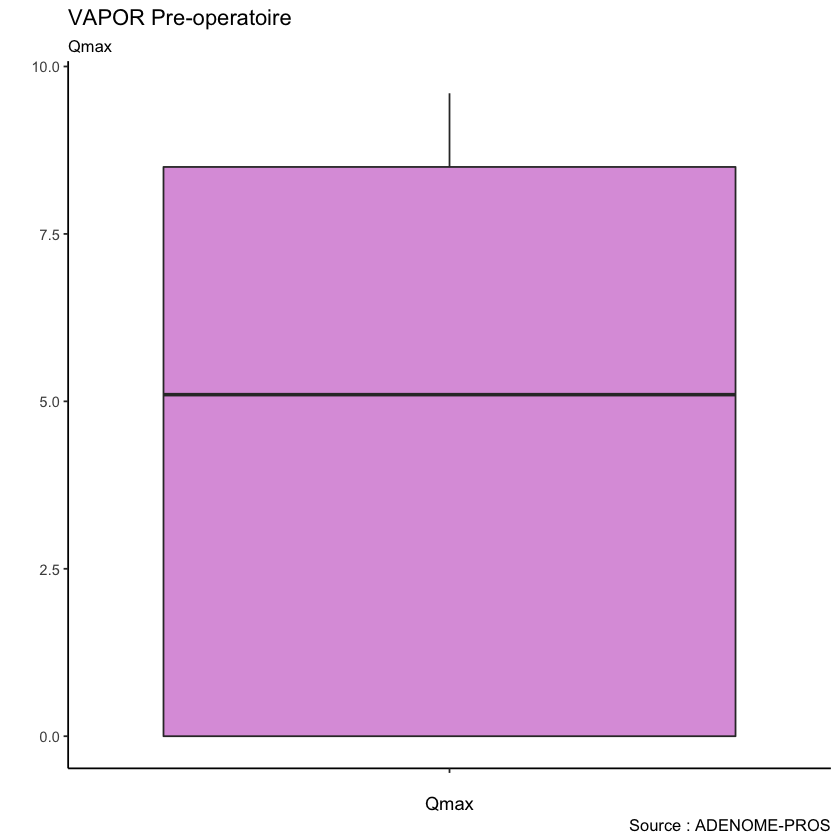

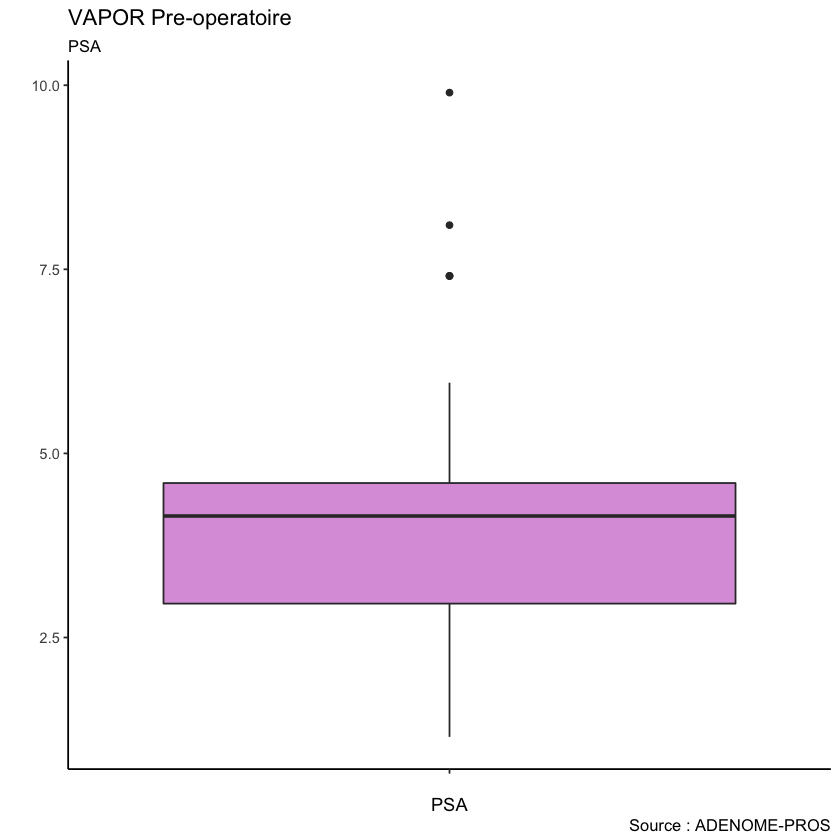

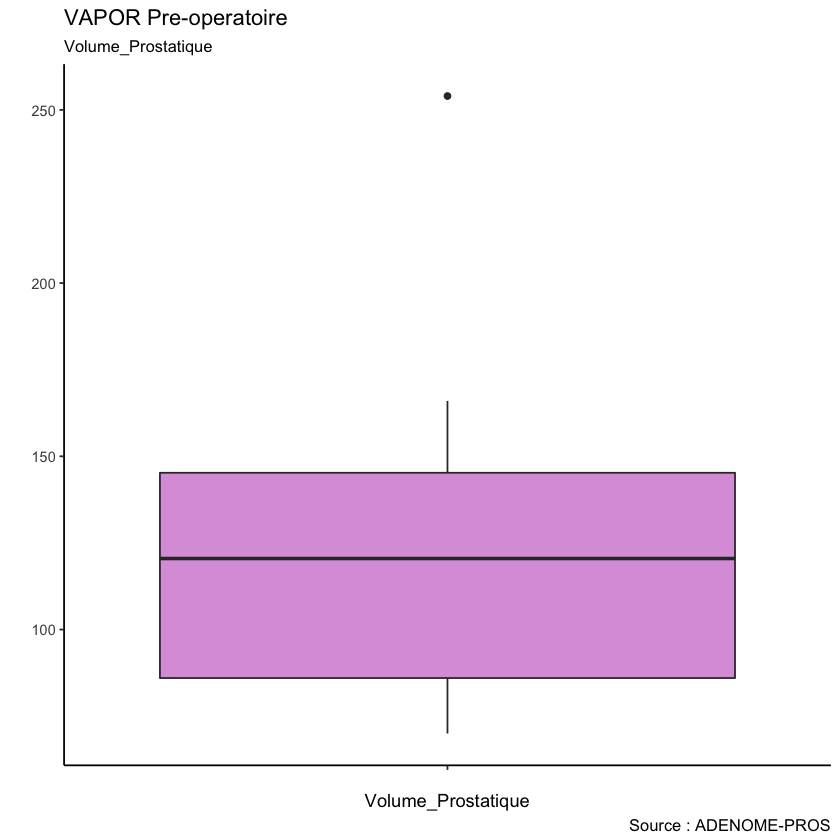

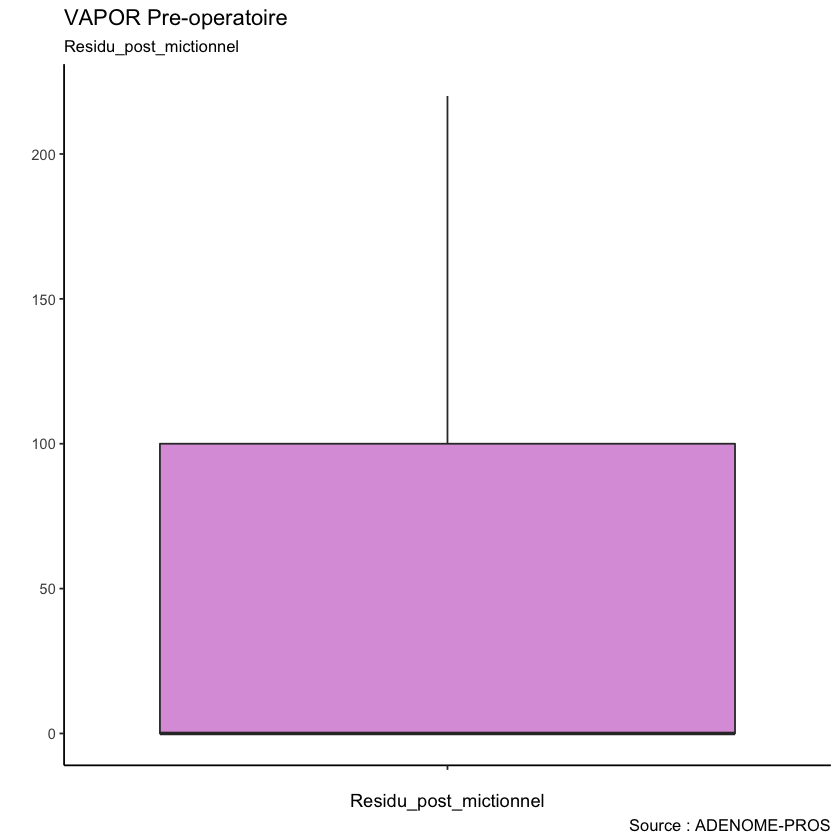

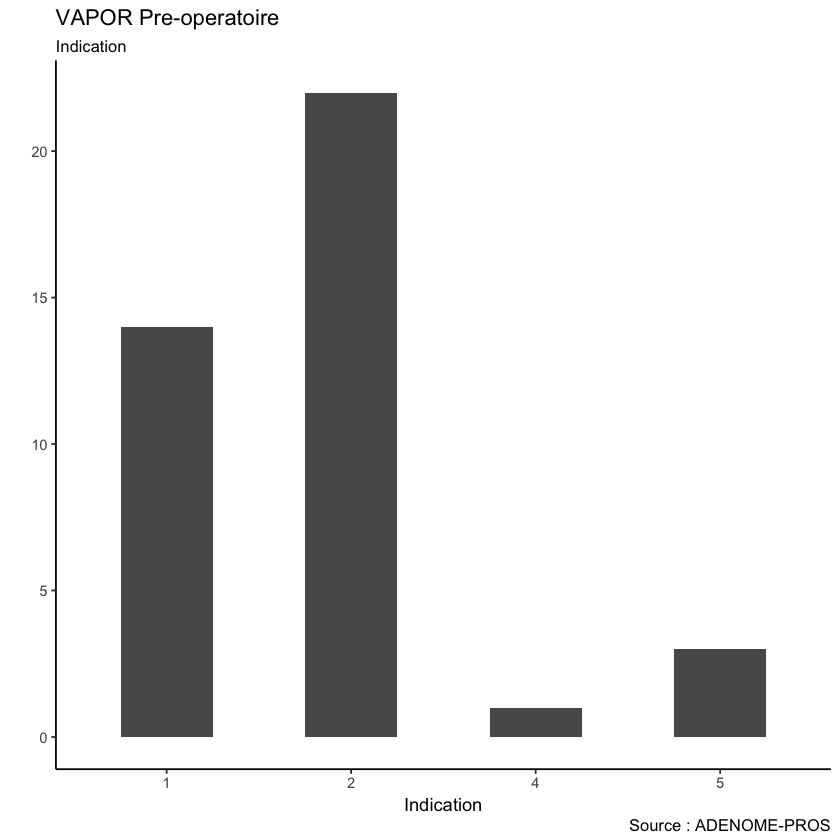

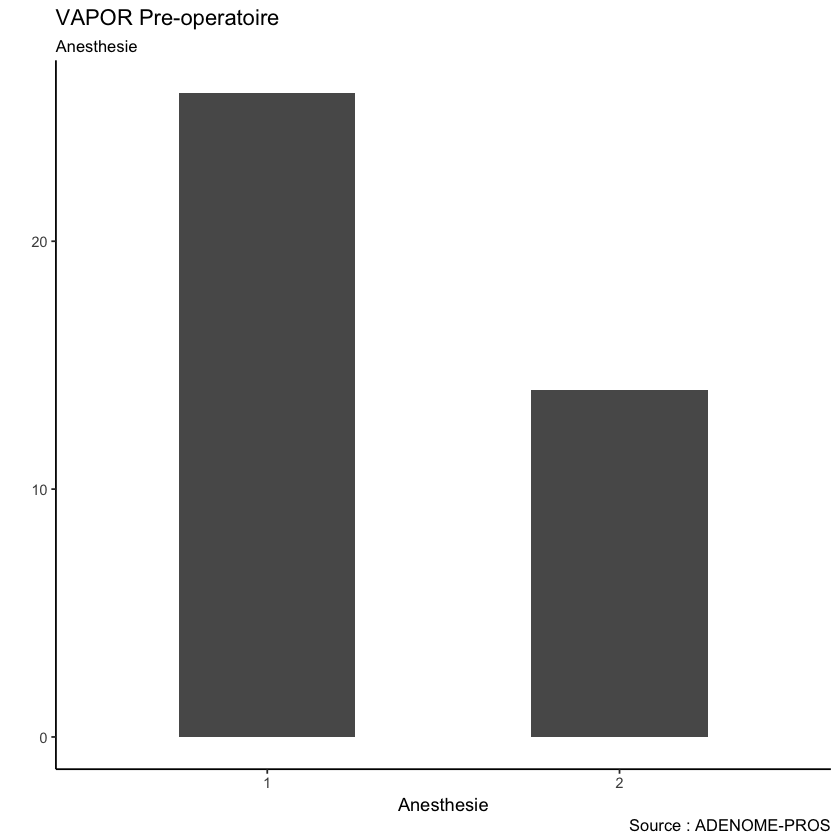

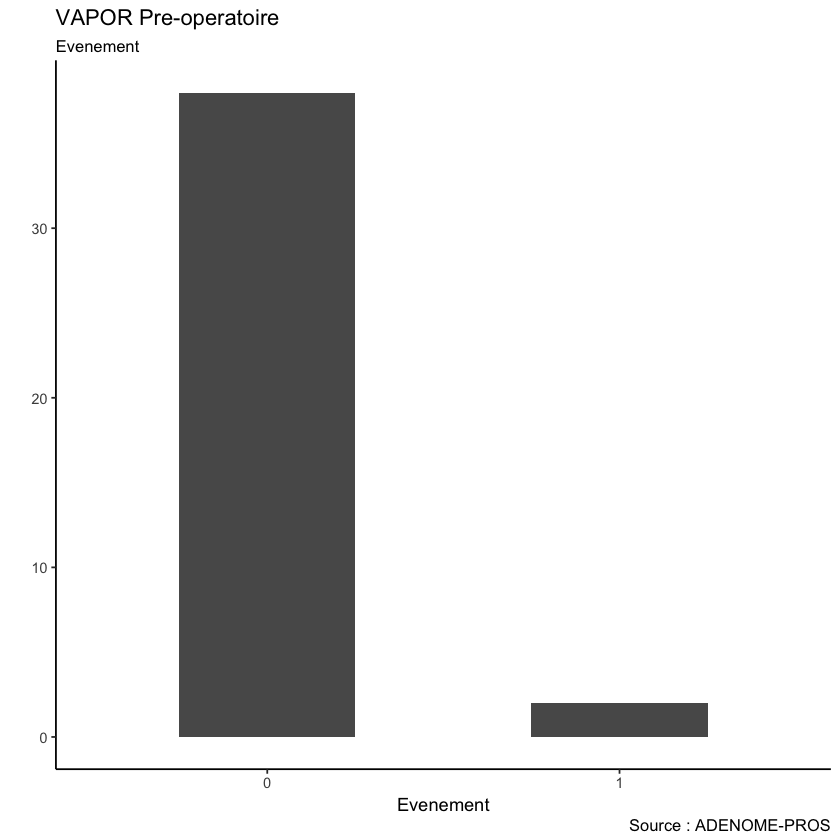

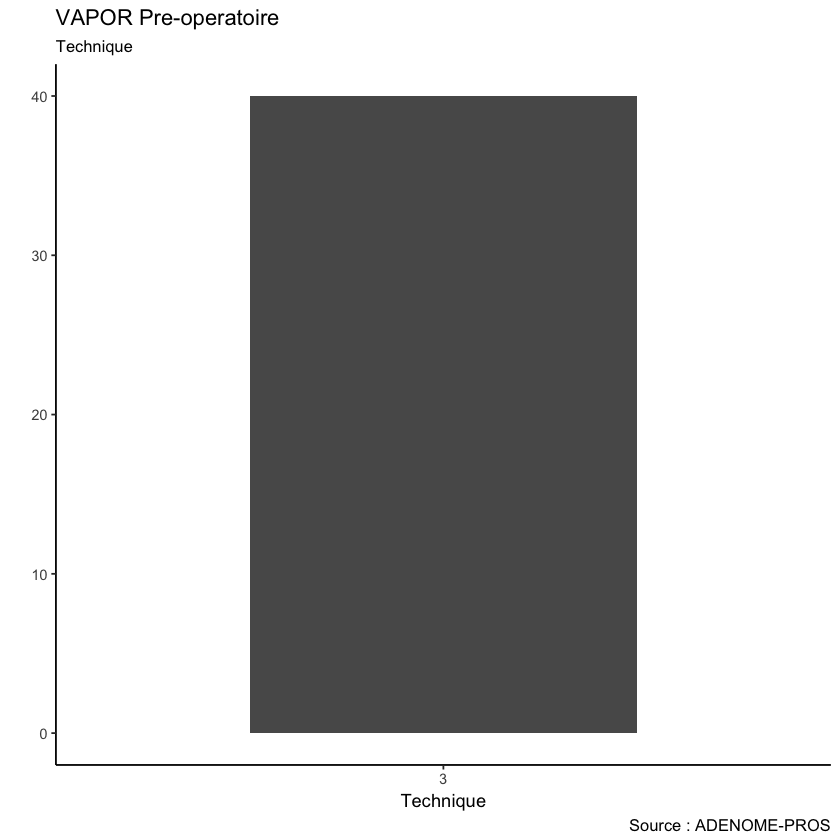

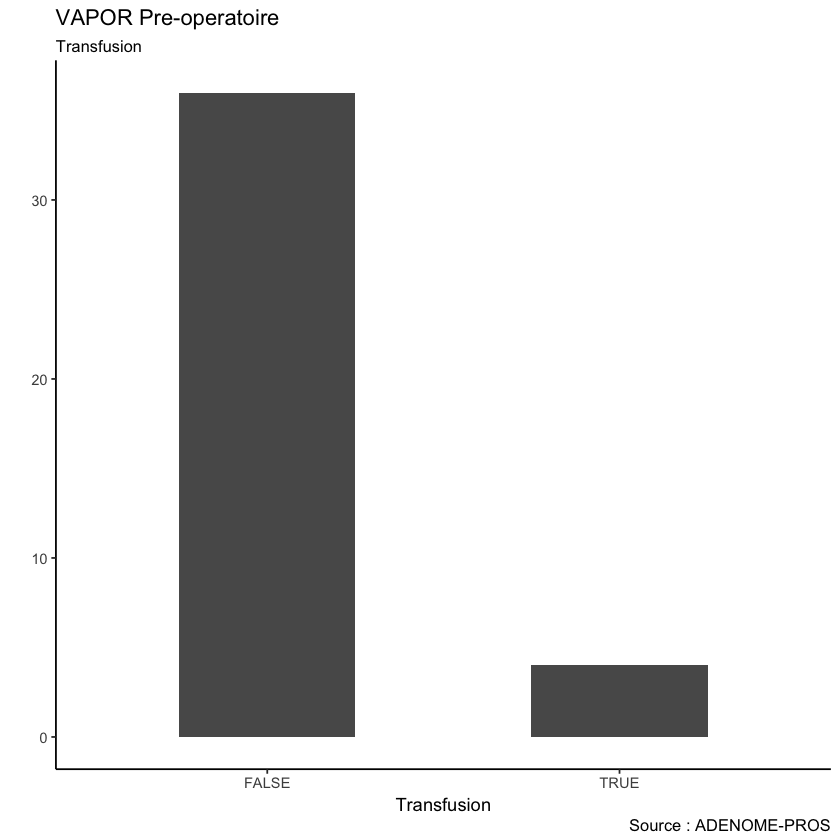

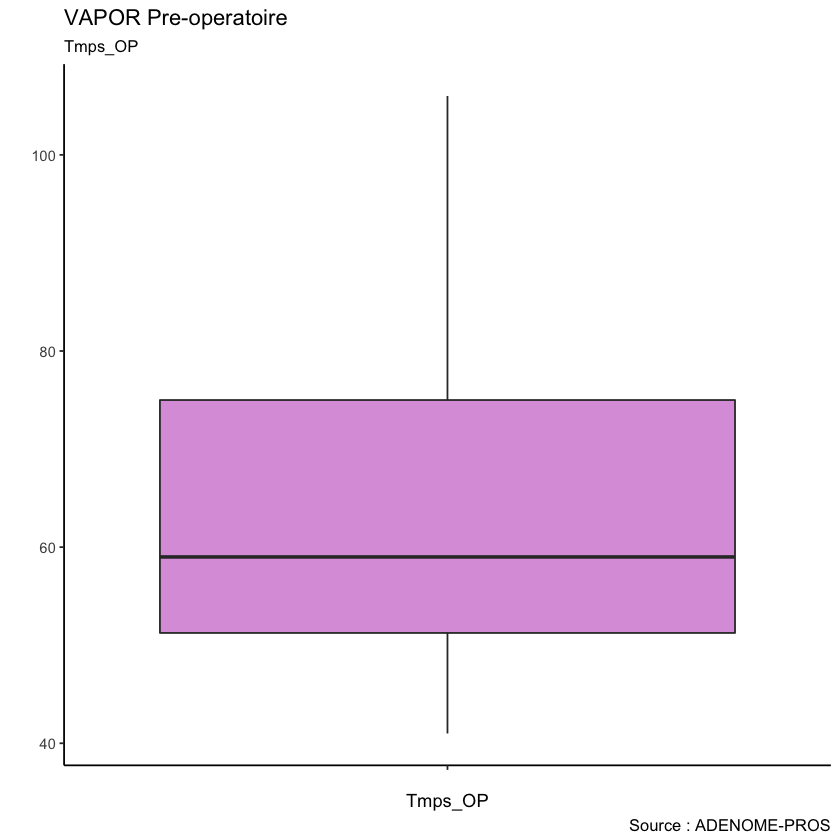

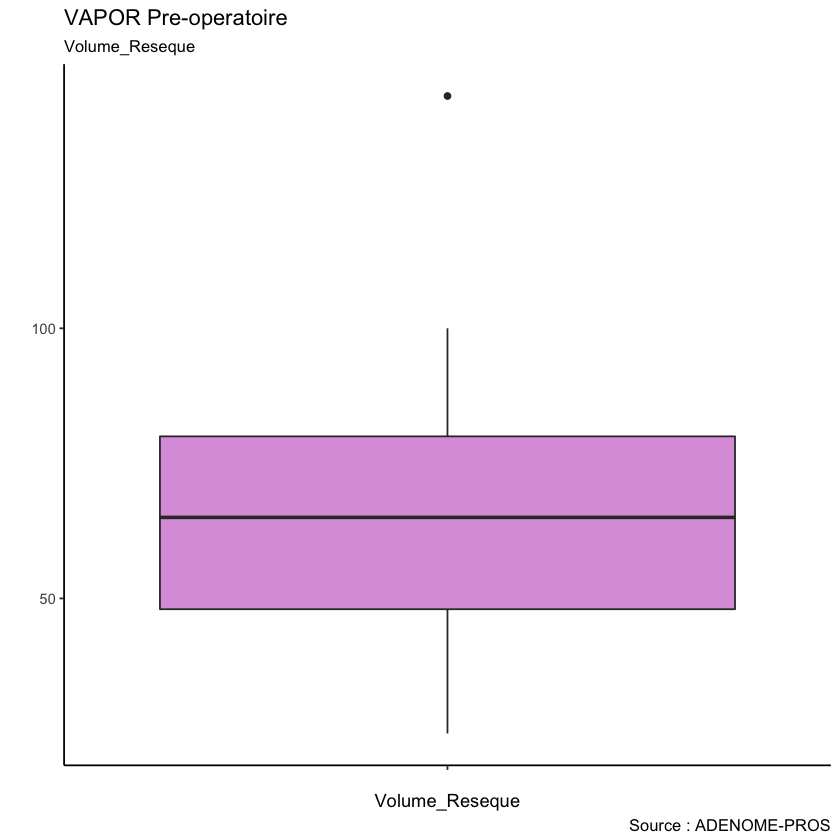

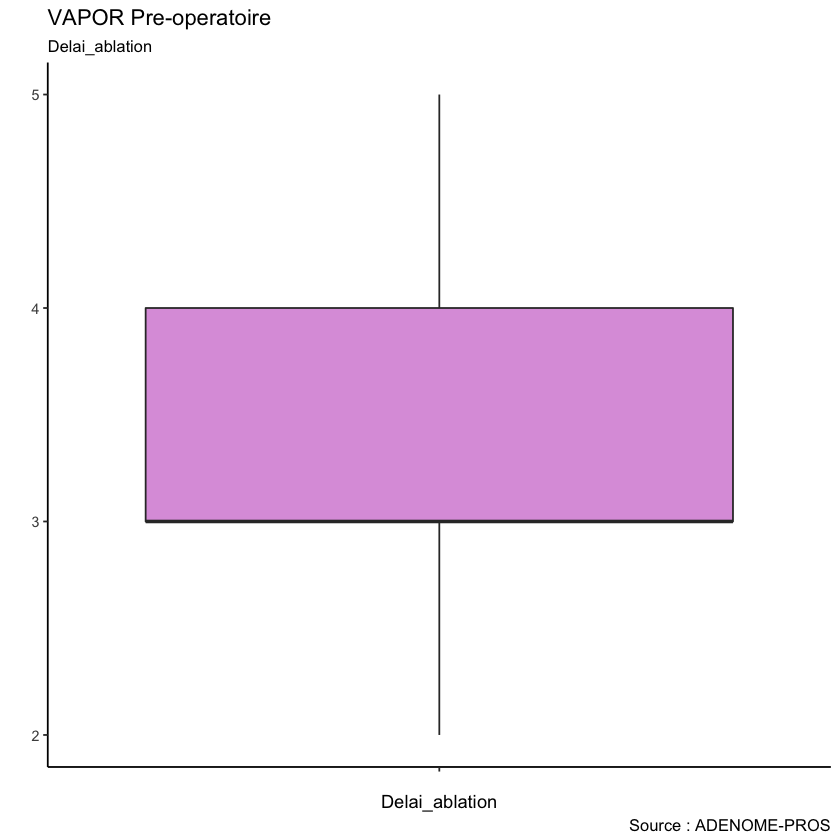

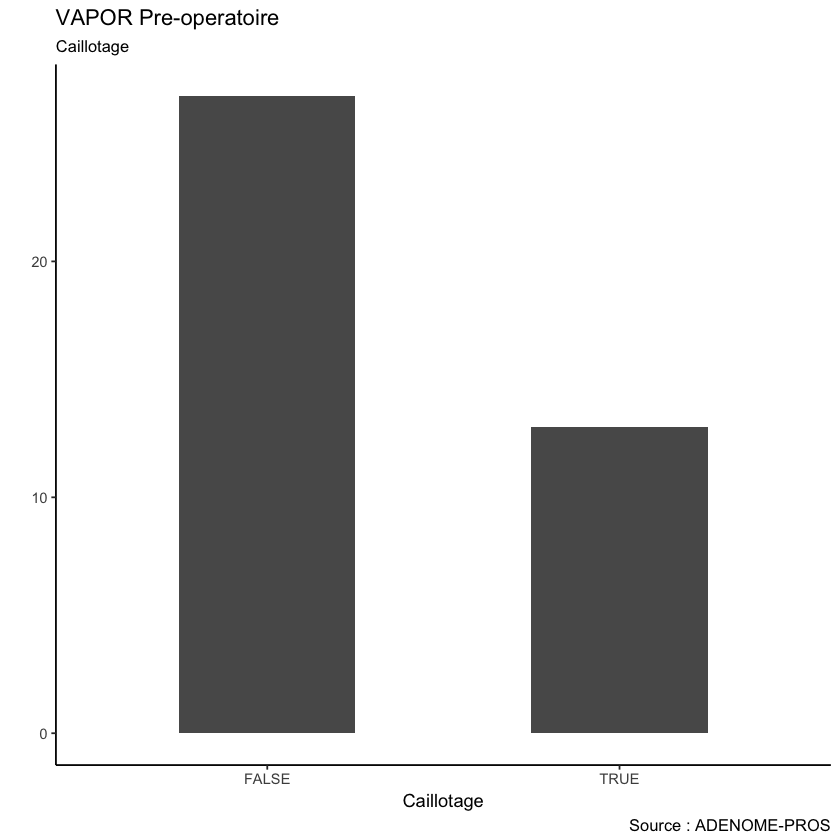

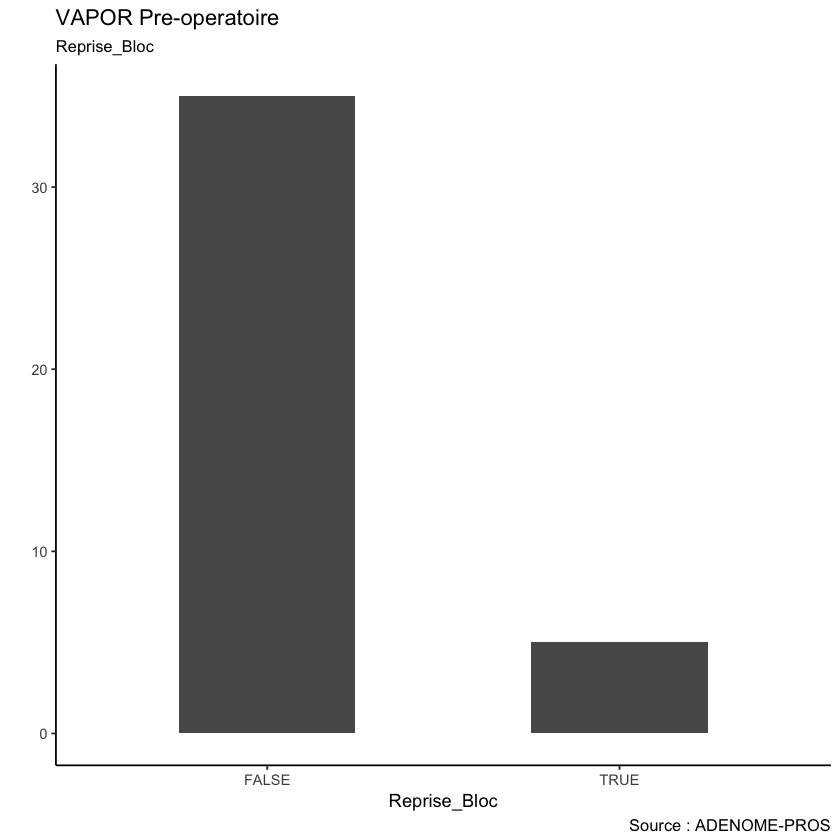

In [6]:
# Boxplots des variables numériques et barplots des variables catégoriques

for (i in 1:ncol(vapor_pre)) {
  #x11(display="")
  if (is.numeric(vapor_pre[,i]) || is.integer(vapor_pre[,i])) {
    adenome_boxplot(vapor_pre,i,"VAPOR Pre-operatoire")
  }
  else
    adenome_barplot(vapor_pre,i,"VAPOR Pre-operatoire")
}

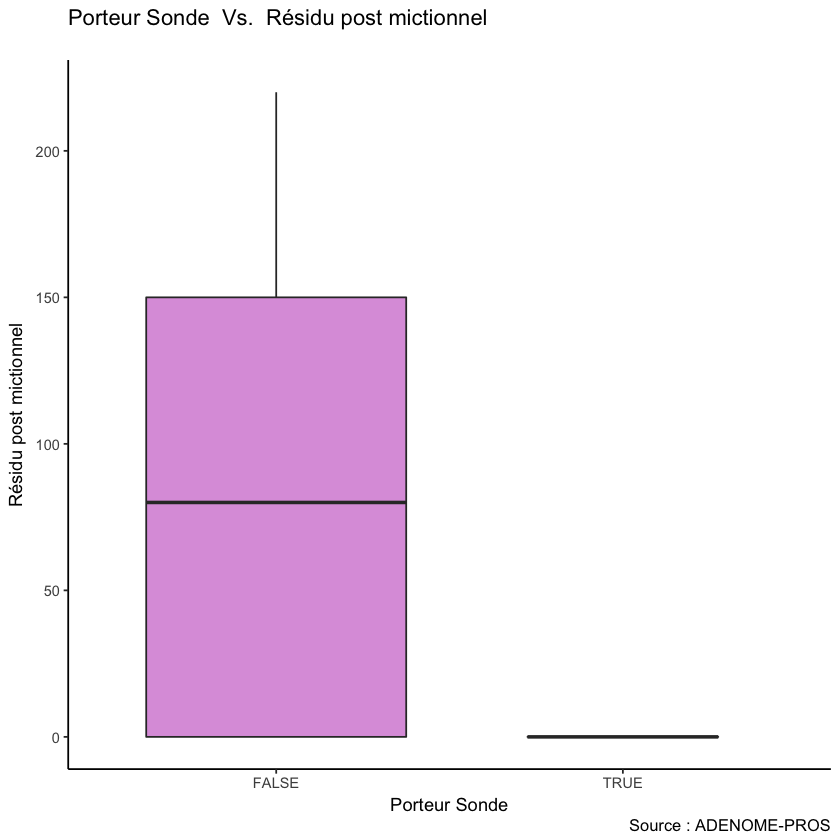

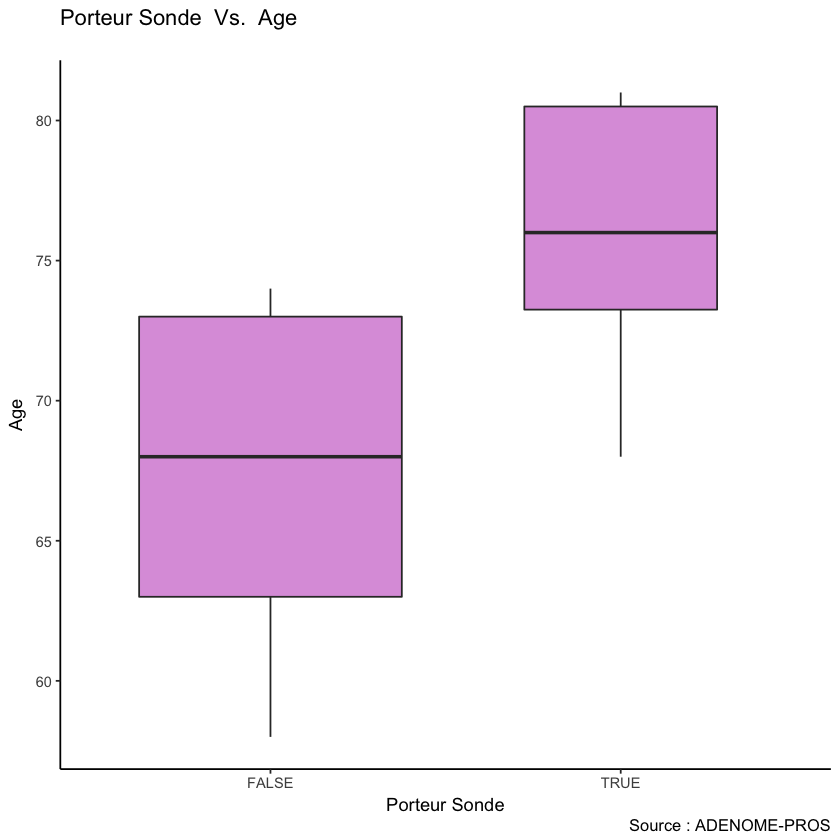

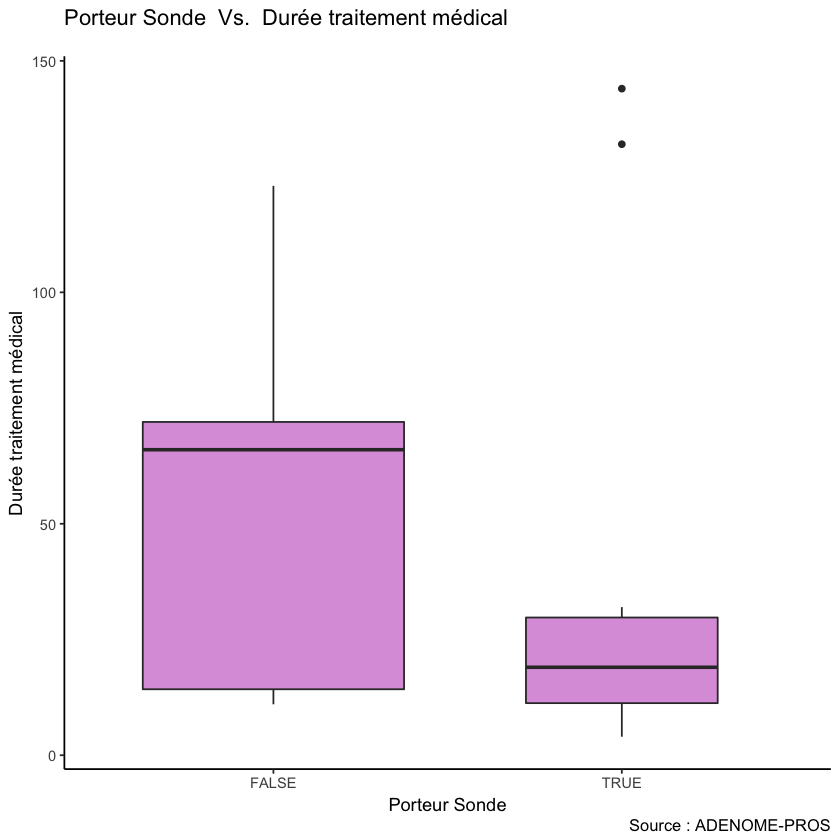

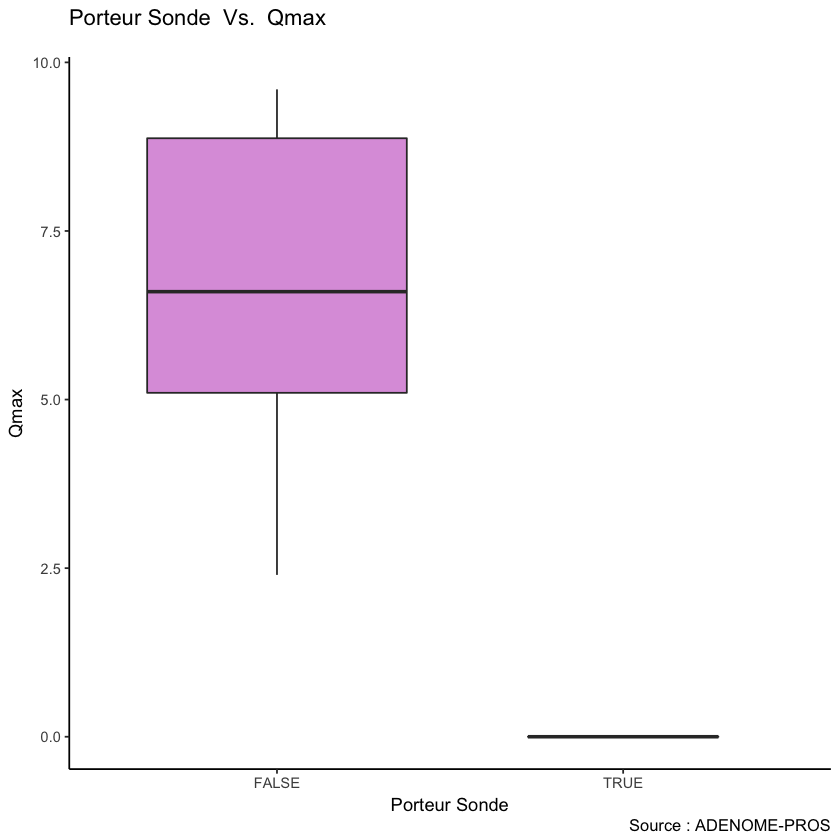

In [7]:
# Quelques distributions par rapport aux porteurs de sondes
adenome_boxplot_couple(vapor_pre, vapor_pre$Porteur_Sonde, vapor_pre$Residu_post_mictionnel, "Porteur Sonde", "Résidu post mictionnel")
adenome_boxplot_couple(vapor_pre, vapor_pre$Porteur_Sonde, vapor_pre$Age, "Porteur Sonde", "Age")
adenome_boxplot_couple(vapor_pre, vapor_pre$Porteur_Sonde, vapor_pre$Duree_Traitement_Medical, "Porteur Sonde", "Durée traitement médical")
adenome_boxplot_couple(vapor_pre, vapor_pre$Porteur_Sonde, vapor_pre$Qmax, "Porteur Sonde", "Qmax")

Logiquement, tous les porteurs de sonde ont un résidu mictionnel = 0. La qualité de leur miction n'est pas évaluée.
Les porteurs de sonde sont plus agés.
Les porteurs de sonde ont un traitement moins long.

### 1.1.2 Corrélations Heatmap

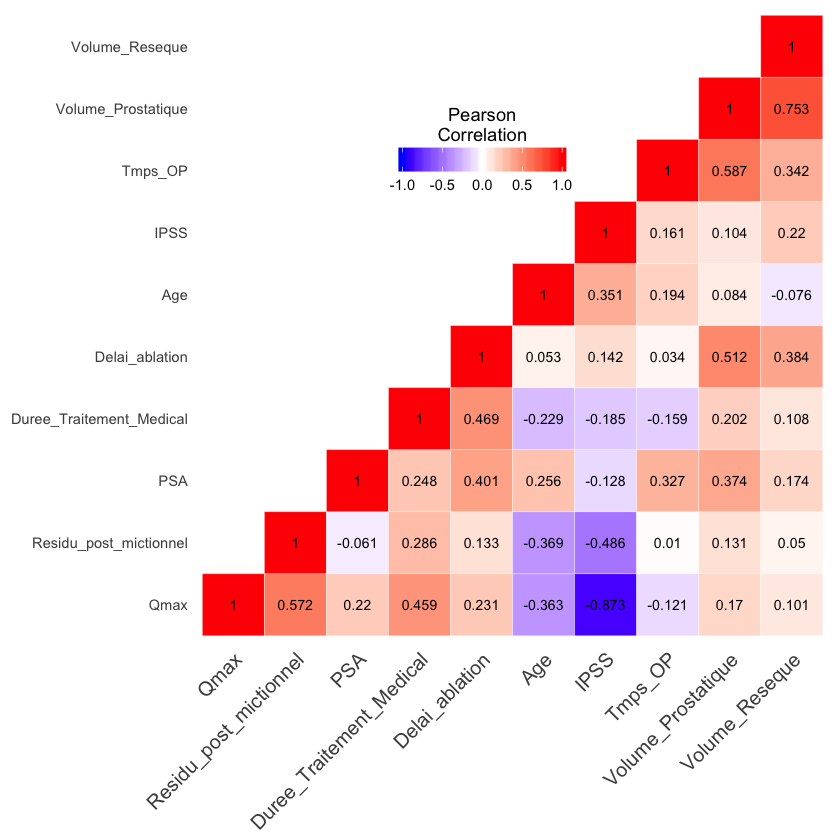

In [8]:
mat_cor_vapor_num_pre = cor(vapor_num_pre, method = c("pearson"))
adenome_heatmap(mat_cor_vapor_num_pre)

Pour la technique VAPOR, en pré-opératoire, nous notons une corrélation entre le "Volume Résequé" et le "Volume prostatique" ainsi qu'une corrélation négative entre "QMax"" et "IPSS". Plus la miction est bonne, plus la gêne est faible.
Dans une moindre mesure, nous notons une corrélation entre "Volume prostatique" et les variables suivantes :
- Temps OP
- Délai Ablation

Nous notons enfin une corrélation entre "Durée Traitement Médical" et "Délai Ablation".

Ces corrélations peuvent être confirmées par les Scatterplots ci-dessous.

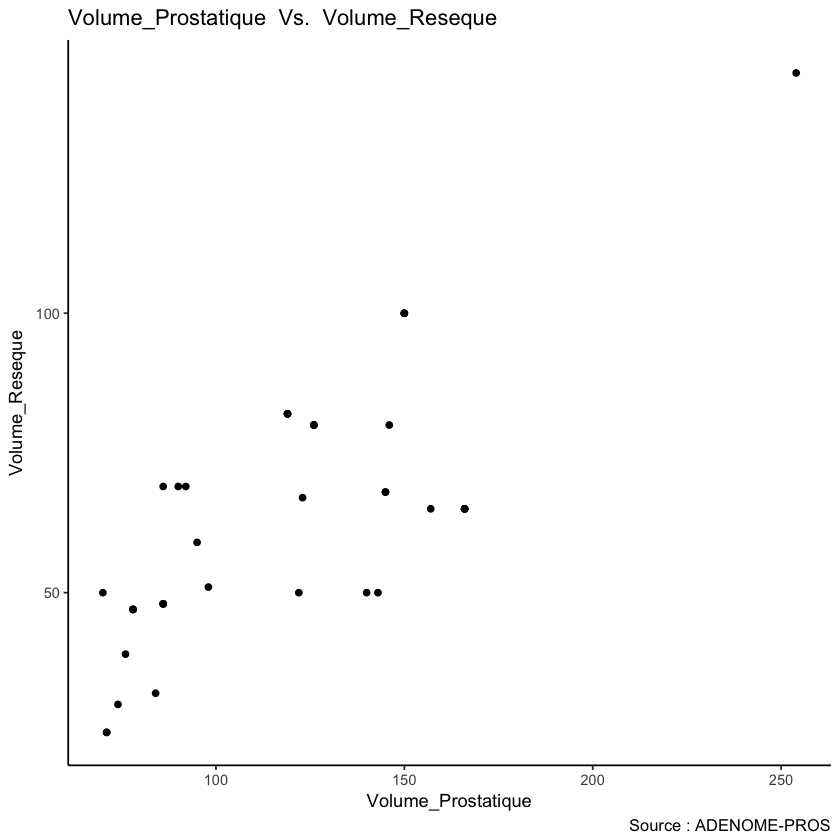

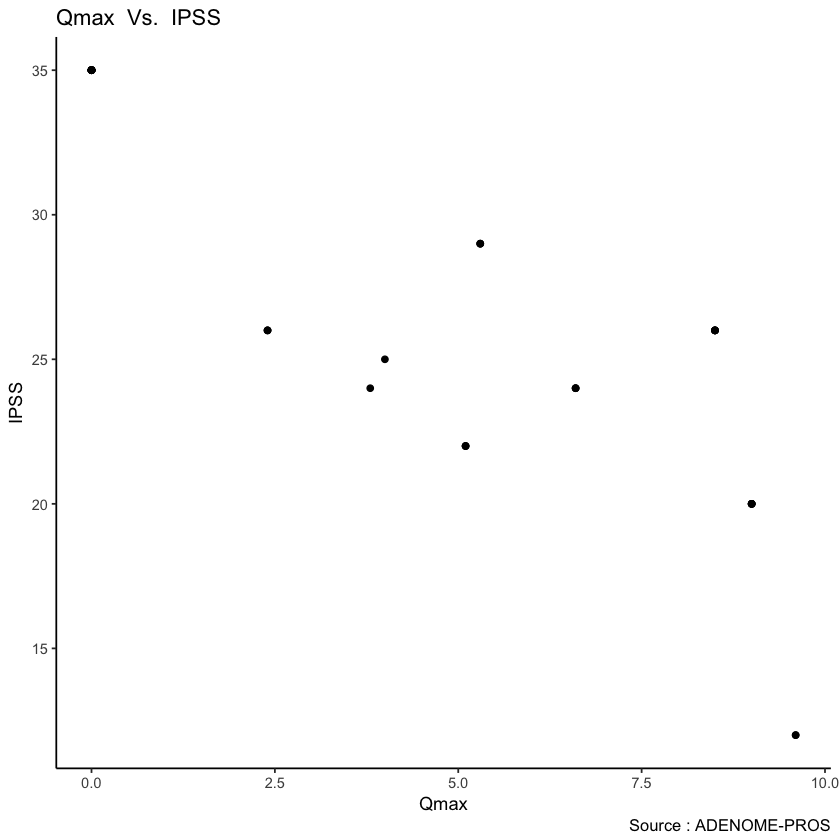

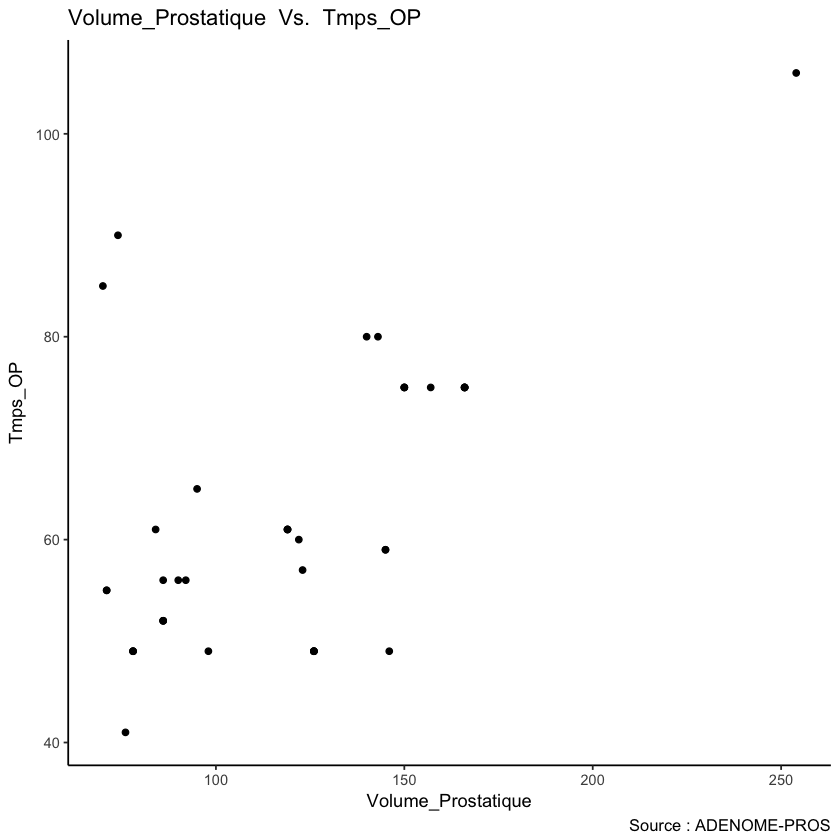

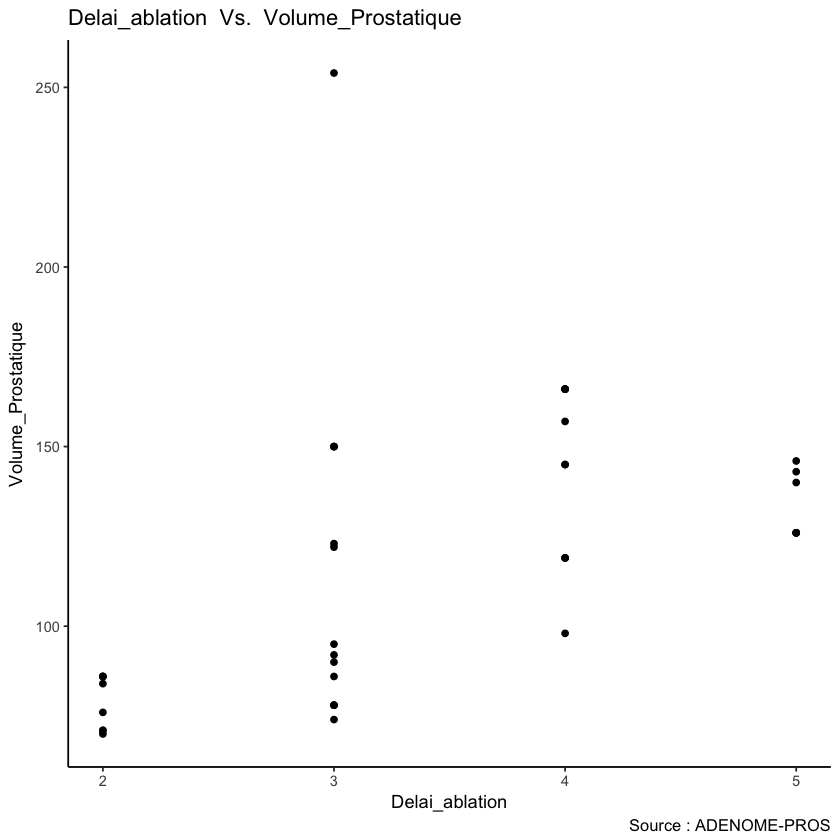

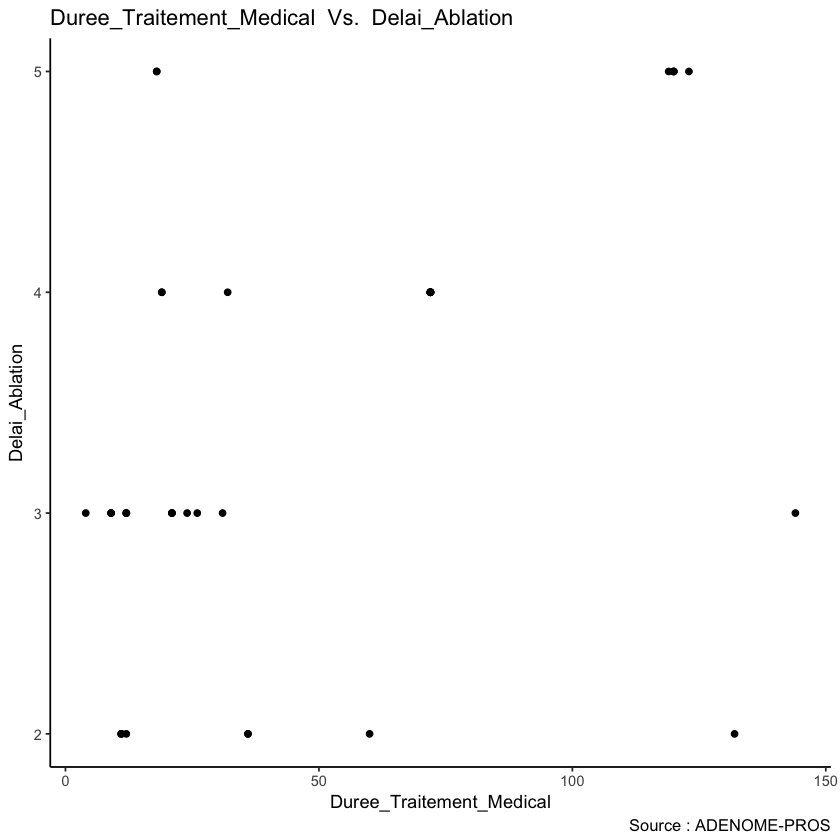

In [9]:
adenome_scatterplot(vapor_pre,vapor_pre$Volume_Prostatique,vapor_pre$Volume_Reseque,"Volume_Prostatique","Volume_Reseque")
adenome_scatterplot(vapor_pre,vapor_pre$Qmax,vapor_pre$IPSS,"Qmax","IPSS")
adenome_scatterplot(vapor_pre,vapor_pre$Volume_Prostatique,vapor_pre$Tmps_OP,"Volume_Prostatique","Tmps_OP")
adenome_scatterplot(vapor_pre,vapor_pre$Delai_ablation,vapor_pre$Volume_Prostatique,"Delai_ablation","Volume_Prostatique")
adenome_scatterplot(vapor_pre,vapor_pre$Duree_Traitement_Medical,vapor_pre$Delai_ablation,"Duree_Traitement_Medical","Delai_Ablation")

### 1.1.3 Corrélations de Kendall

Le coefficient de corrélation de Kendall est basé sur les rangs.

In [10]:
mat_cor_vapor_cat_pre = cor(vapor_cat_pre, method = c("kendall"))

ERROR: Error in cor(vapor_cat_pre, method = c("kendall")): 'x' must be numeric


In [11]:
tableau <- table (vapor_cat_pre) 
print(tableau)

, , QoL = 5, Indication = 1, Anesthesie = 1, Evenement = 0, Technique = 3, Transfusion = FALSE, Caillotage = FALSE, Reprise_Bloc = FALSE

           Porteur_Sonde
Comorbidite FALSE TRUE
      FALSE     0    0
      TRUE      0    0

, , QoL = 6, Indication = 1, Anesthesie = 1, Evenement = 0, Technique = 3, Transfusion = FALSE, Caillotage = FALSE, Reprise_Bloc = FALSE

           Porteur_Sonde
Comorbidite FALSE TRUE
      FALSE     0    4
      TRUE      0    4

, , QoL = 5, Indication = 2, Anesthesie = 1, Evenement = 0, Technique = 3, Transfusion = FALSE, Caillotage = FALSE, Reprise_Bloc = FALSE

           Porteur_Sonde
Comorbidite FALSE TRUE
      FALSE     0    0
      TRUE      3    0

, , QoL = 6, Indication = 2, Anesthesie = 1, Evenement = 0, Technique = 3, Transfusion = FALSE, Caillotage = FALSE, Reprise_Bloc = FALSE

           Porteur_Sonde
Comorbidite FALSE TRUE
      FALSE     1    0
      TRUE      0    0

, , QoL = 5, Indication = 4, Anesthesie = 1, Evenement = 0, Techniqu

### 1.1.4 Analyse en composantes principales

In [44]:
pca <- stats::prcomp(x=vapor_num_pre)
summary(pca)

Importance of components:
                           PC1     PC2     PC3      PC4     PC5     PC6     PC7
Standard deviation     78.3706 44.8756 38.5778 14.76950 9.55569 6.54533 5.12701
Proportion of Variance  0.6126  0.2009  0.1484  0.02176 0.00911 0.00427 0.00262
Cumulative Proportion   0.6126  0.8134  0.9619  0.98363 0.99274 0.99701 0.99964
                           PC8    PC9    PC10
Standard deviation     1.54771 1.0203 0.46335
Proportion of Variance 0.00024 0.0001 0.00002
Cumulative Proportion  0.99987 1.0000 1.00000

In [41]:
sum(100 * (pca$sdev^2)[1:3] / sum(pca$sdev^2))

[1] 96.18773

Ainsi les trois premières composantes à elles seules contiennent 96.2% de l'information, il est donc raisonnable de garder seulement trois variables en ne perdant que 3.8% d'info.

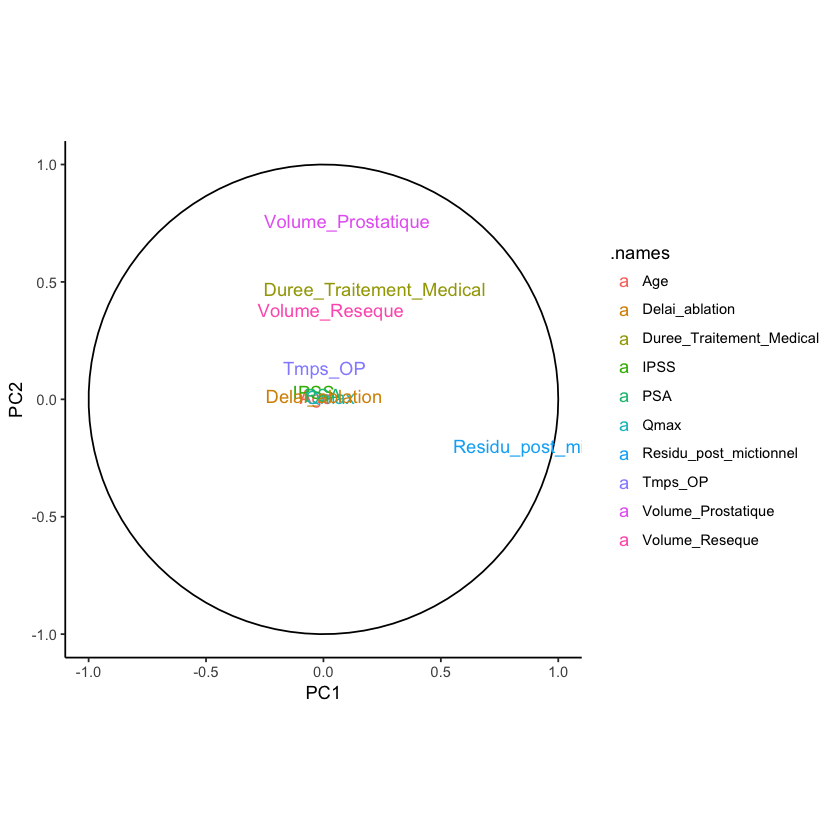

In [46]:
theta <- seq(0,2*pi,length.out = 100)
circle <- data.frame(x = cos(theta), y = sin(theta))
p <- ggplot(circle,aes(x,y)) + geom_path()
loadings <- data.frame(pca$rotation, 
.names = row.names(pca$rotation))
p + geom_text(data=loadings, 
mapping=aes(x = PC1, y = PC2, label = .names, colour = .names)) +
  coord_fixed(ratio=1) +
  labs(x = "PC1", y = "PC2")

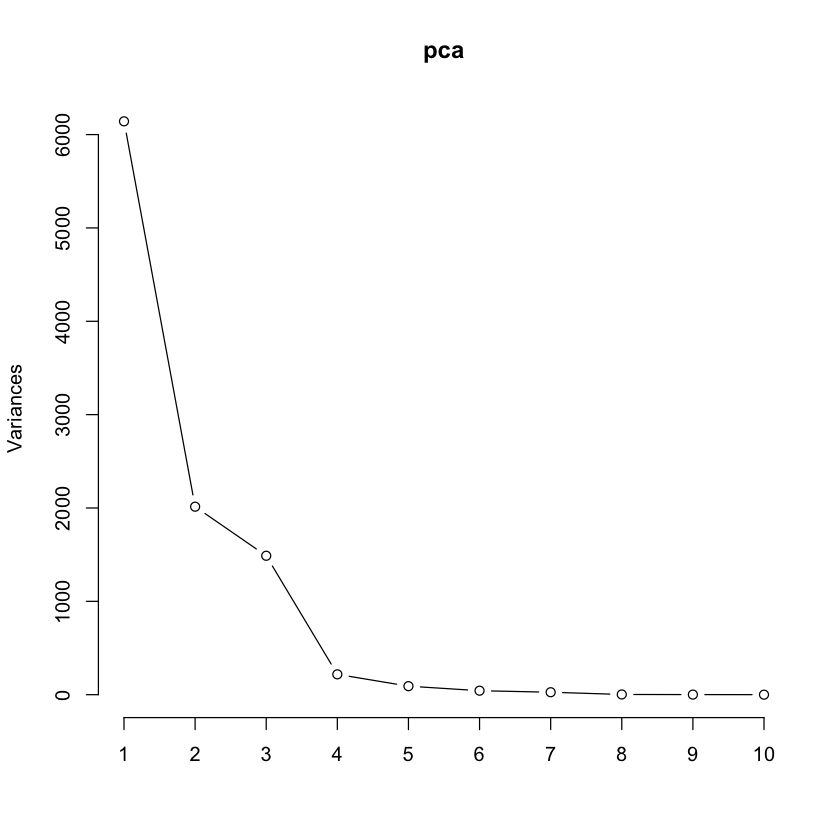

In [36]:
plot(pca, type = "l")

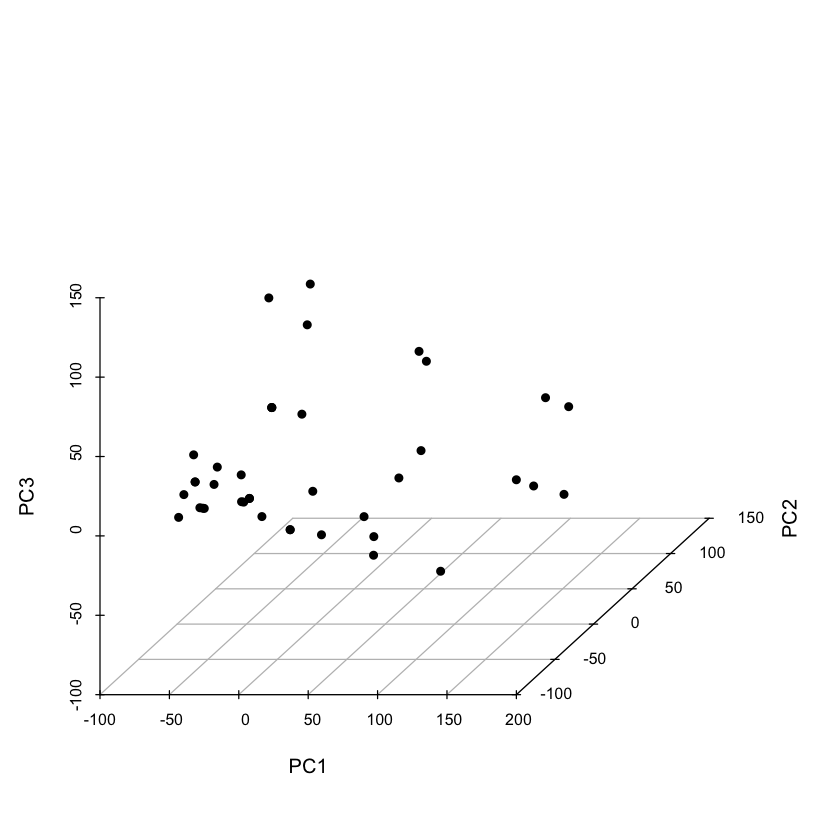

In [49]:
library(scatterplot3d)
scatterplot3d(pca$x[, 1:3], pch = 16, grid=TRUE, box=FALSE)

# 1.2 Post-opératoire

### 1.2.1 Distributions

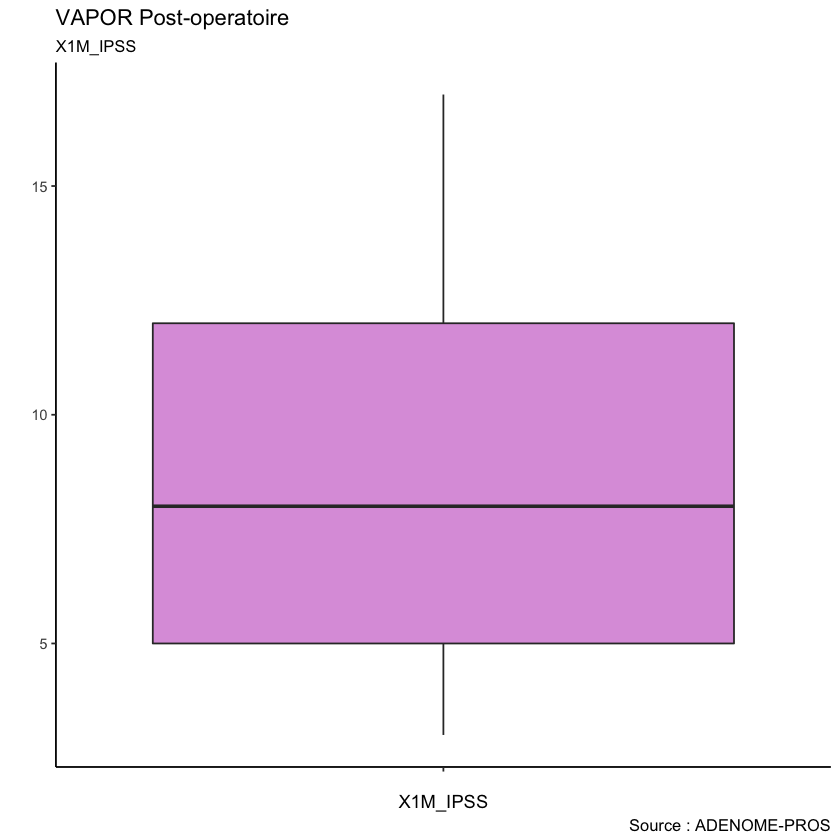

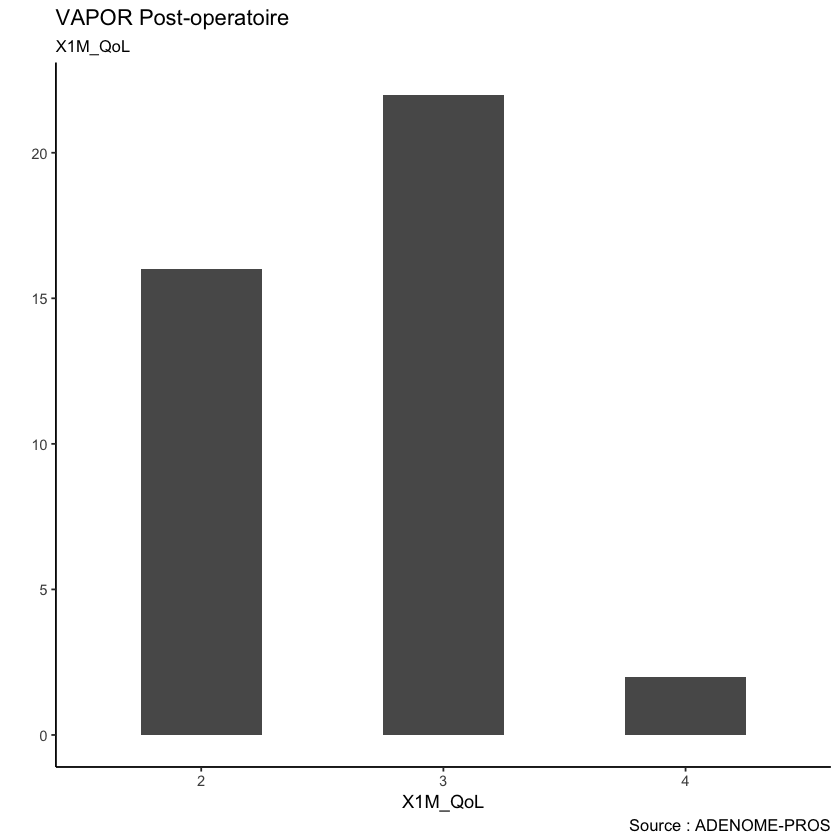

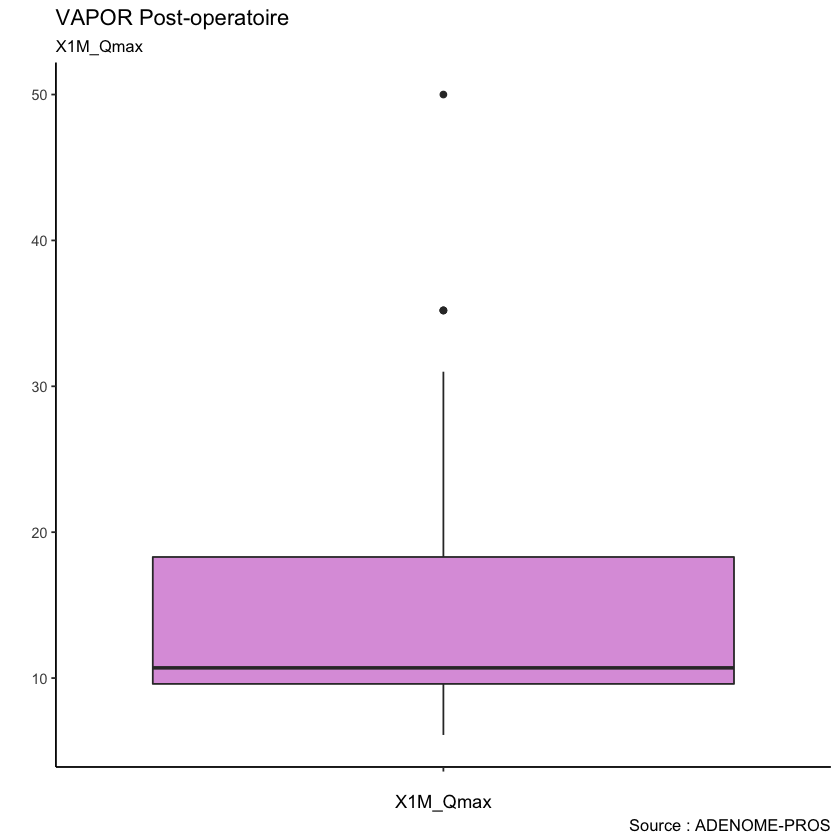

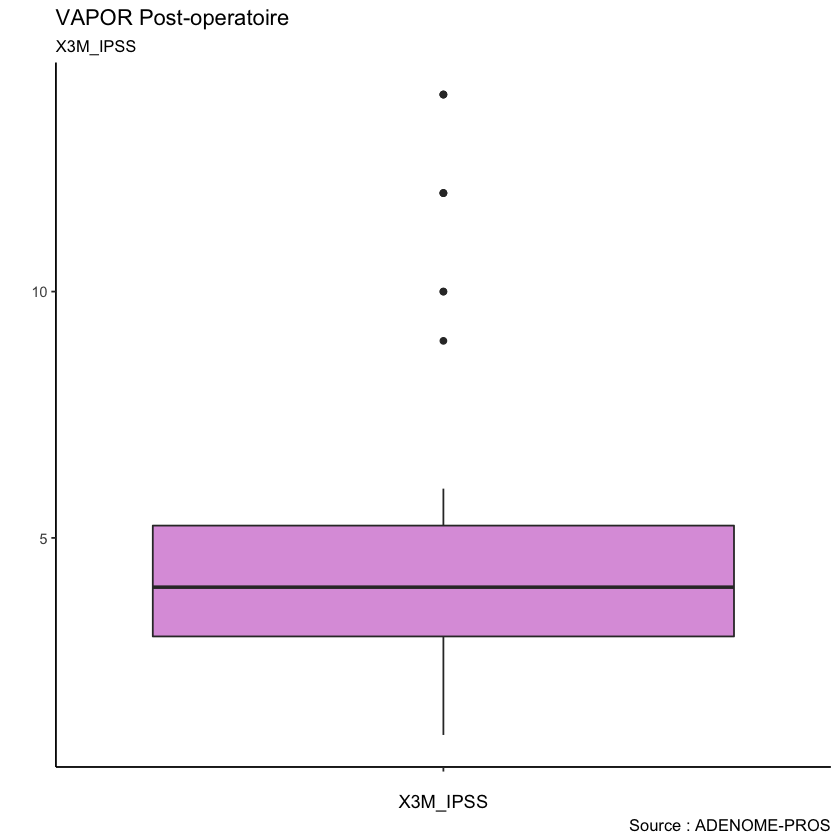

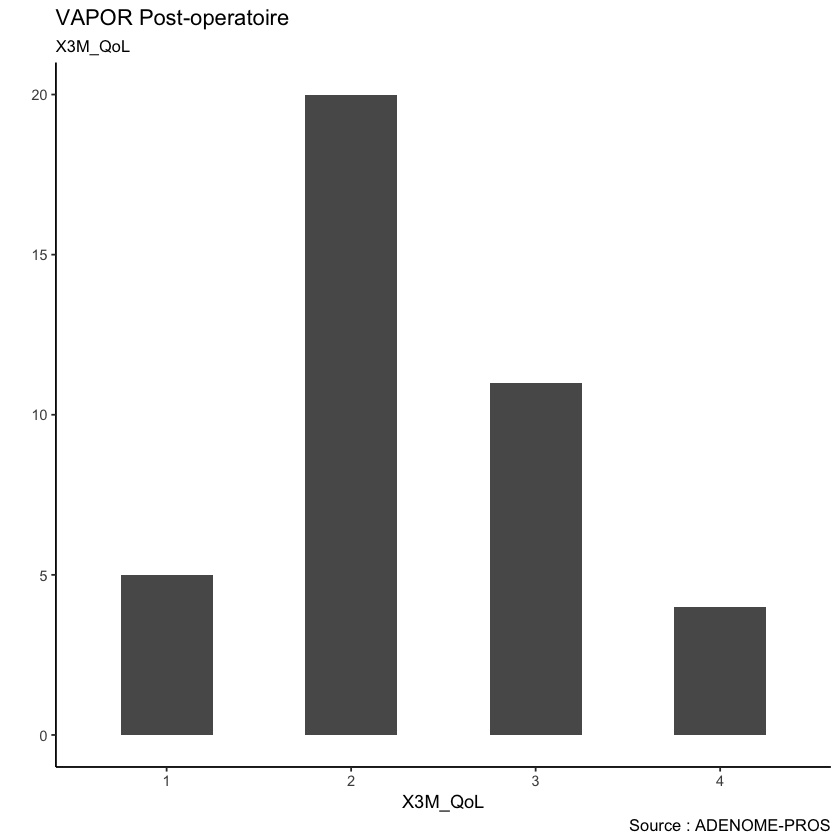

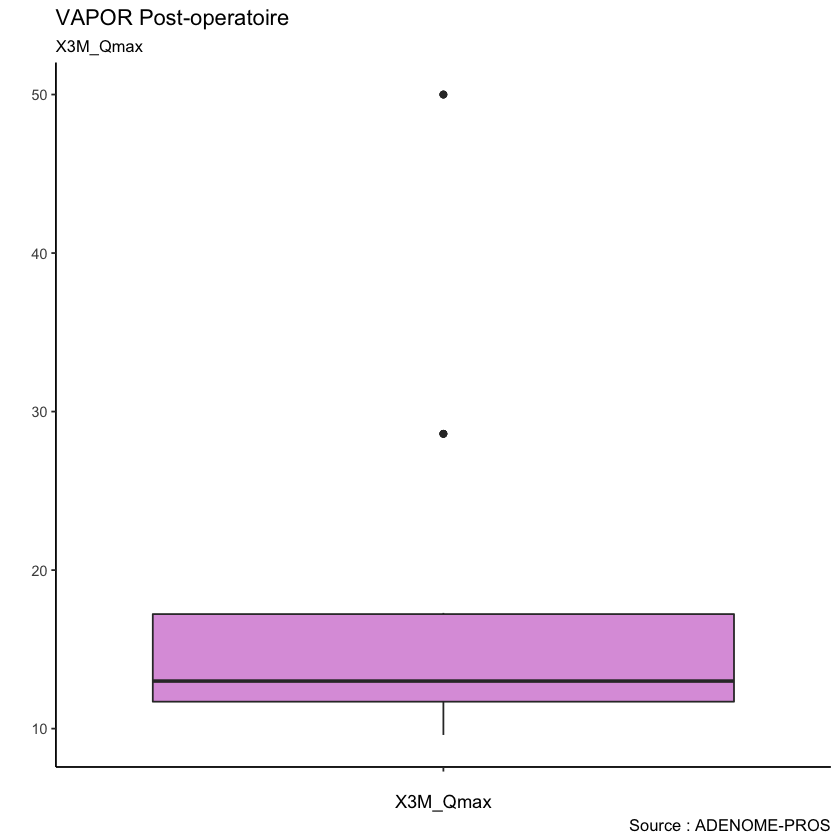

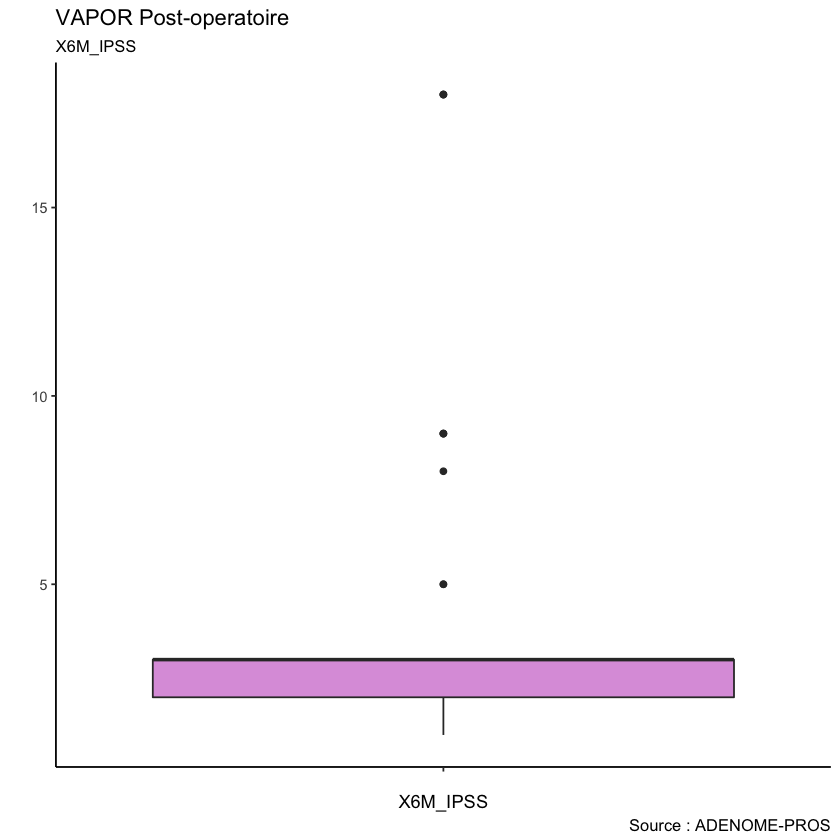

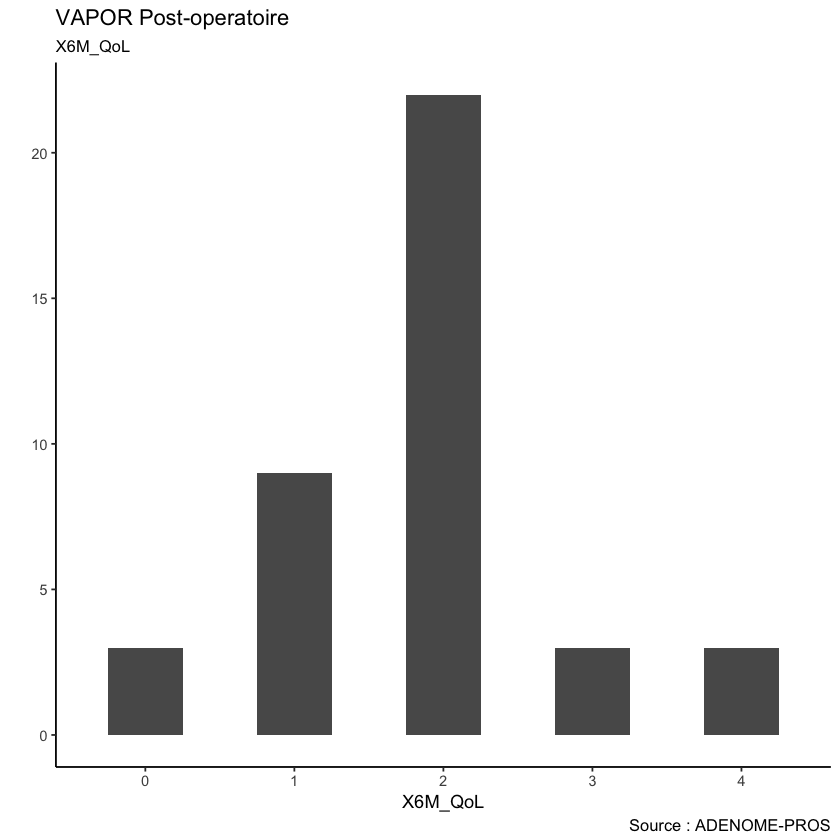

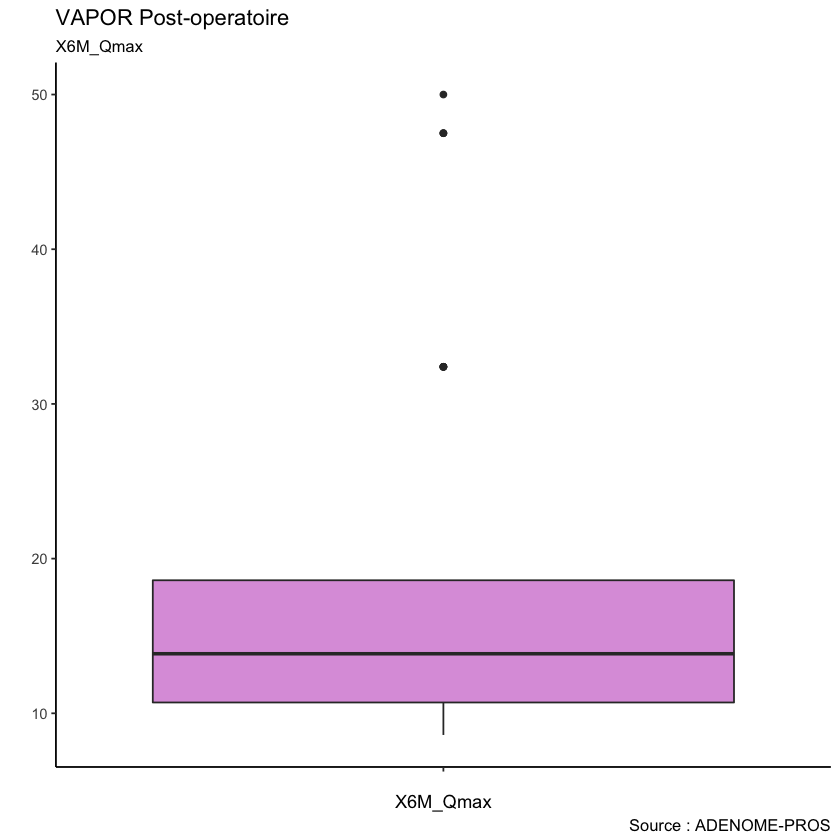

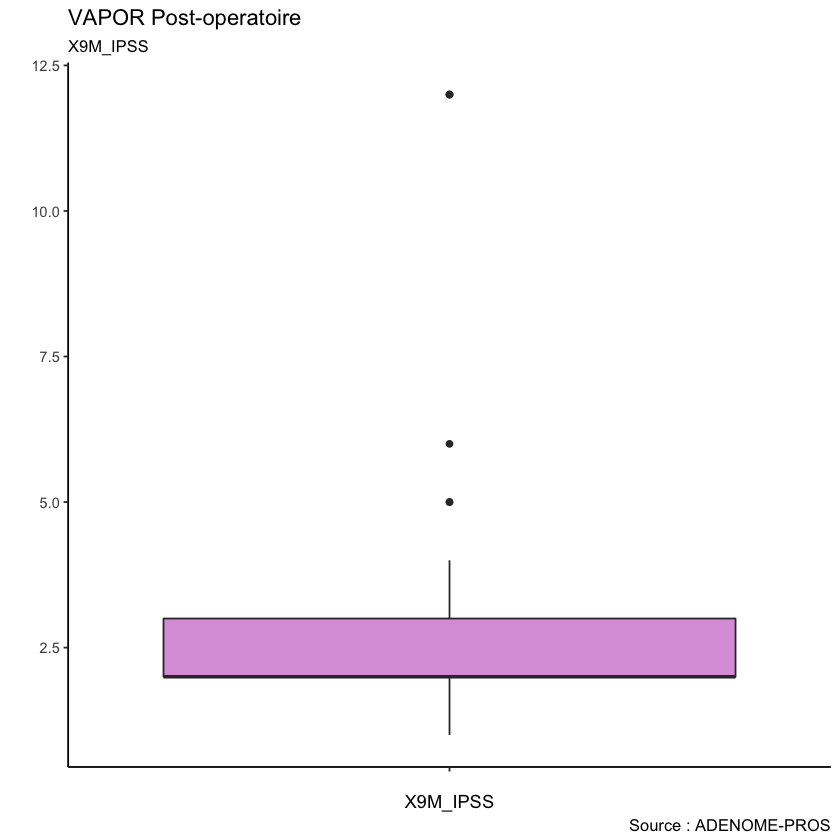

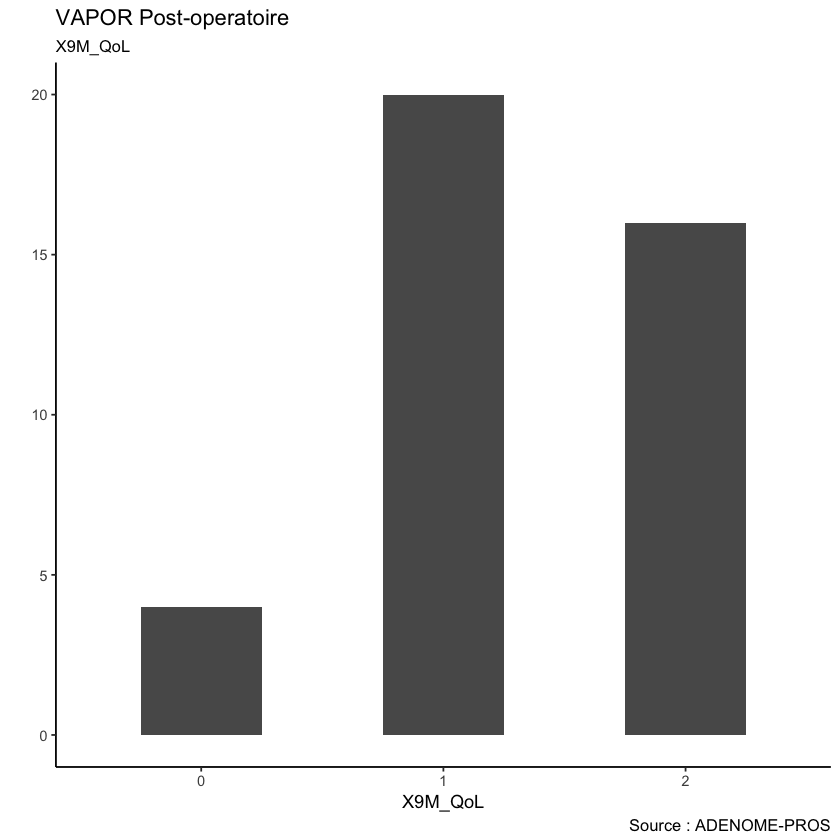

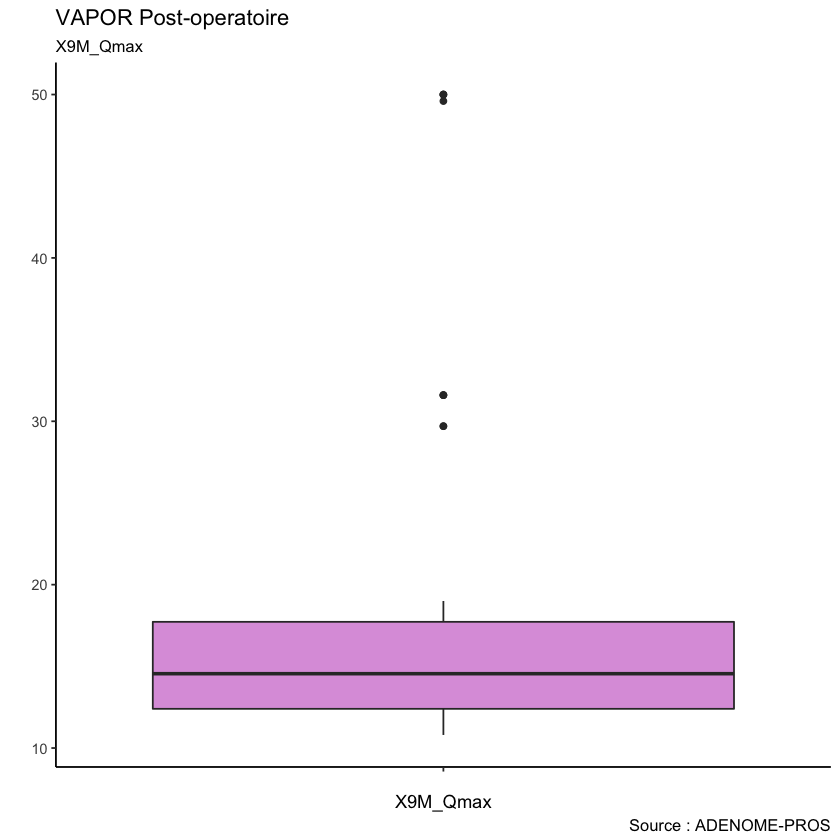

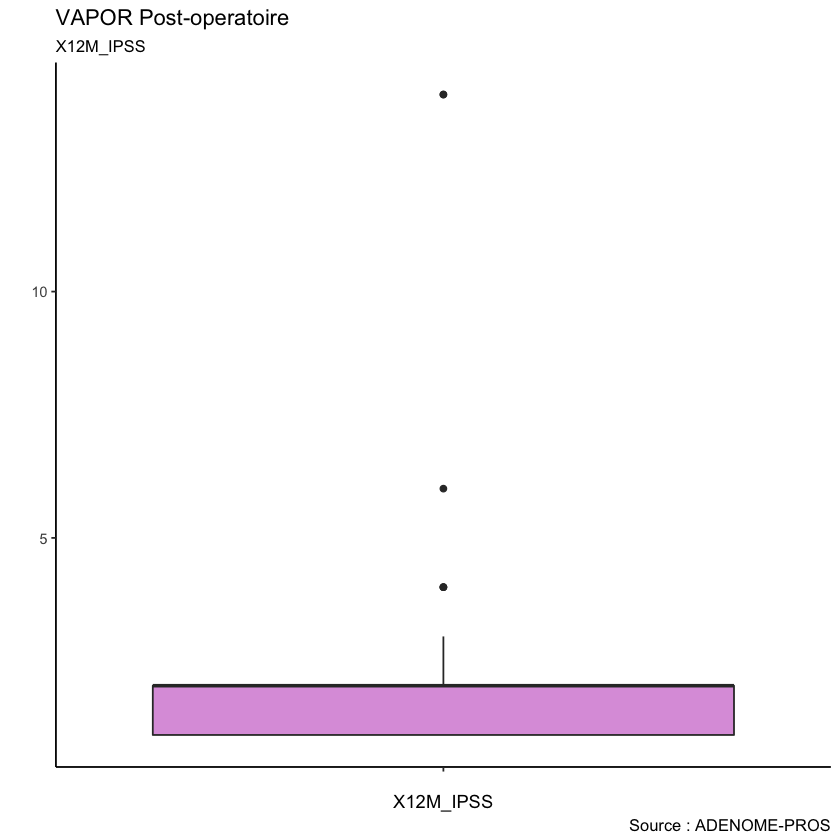

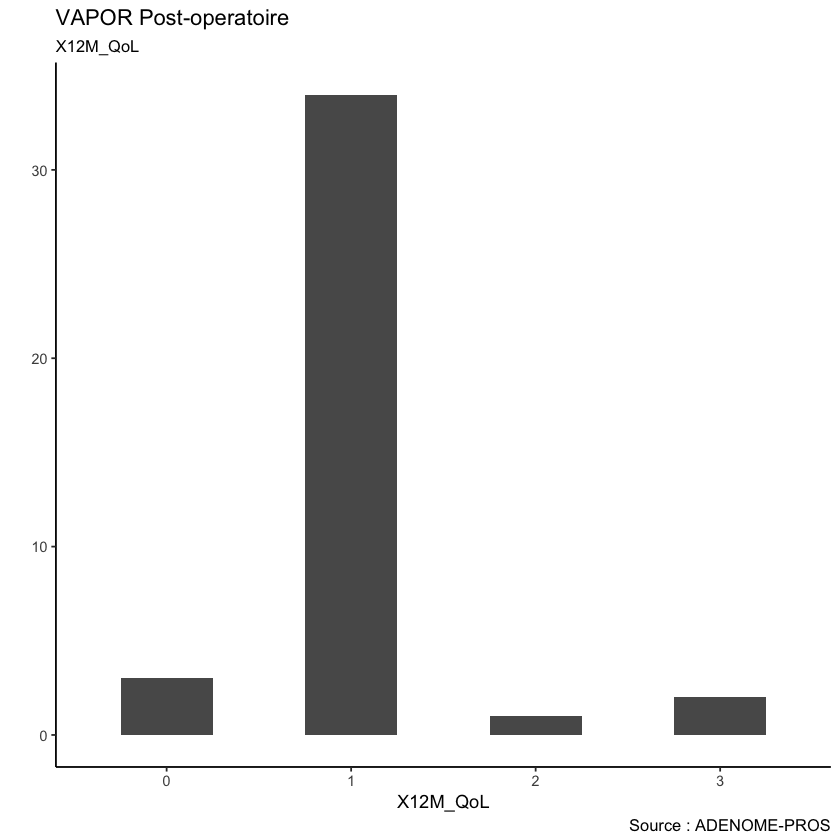

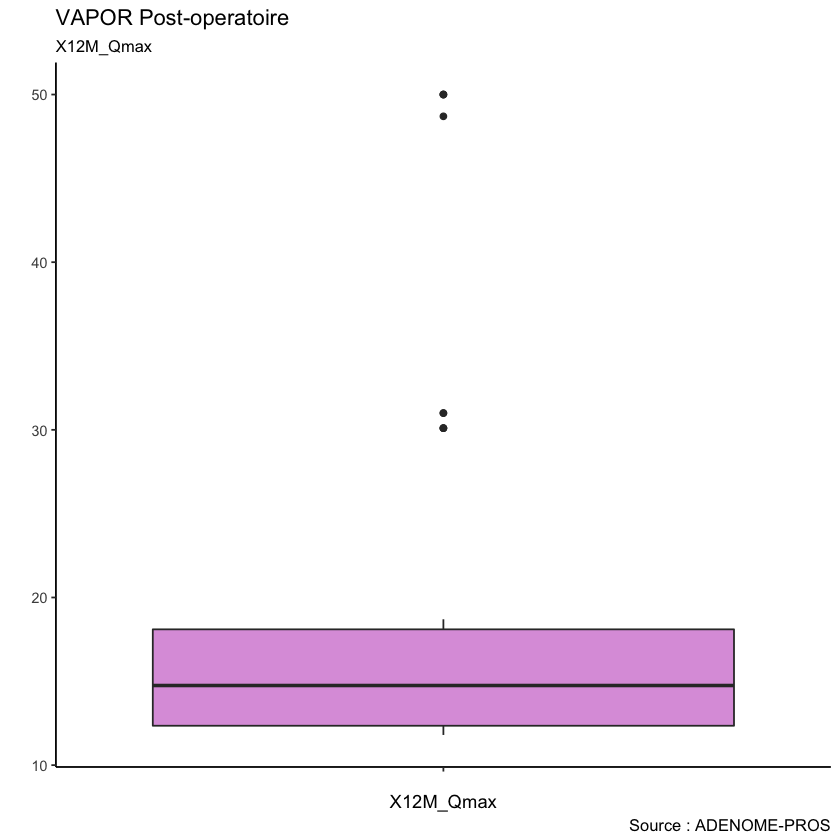

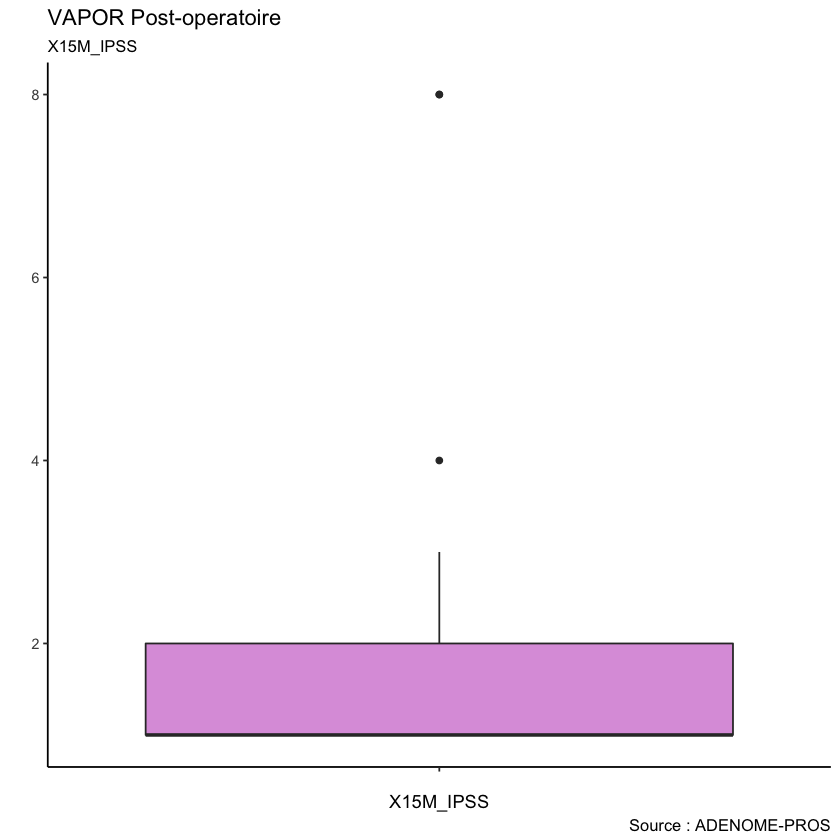

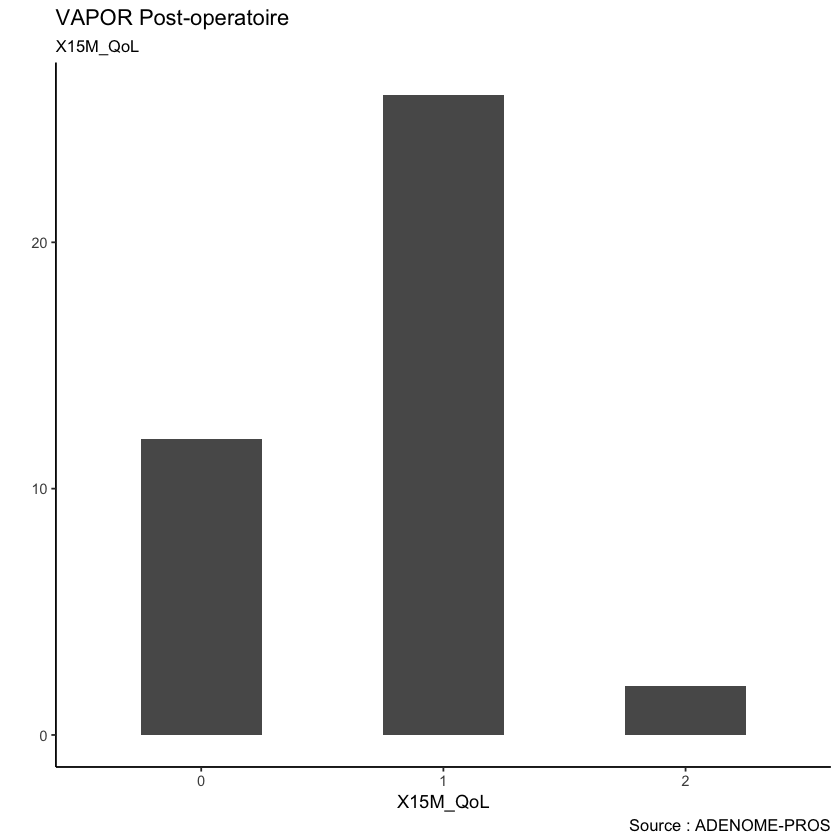

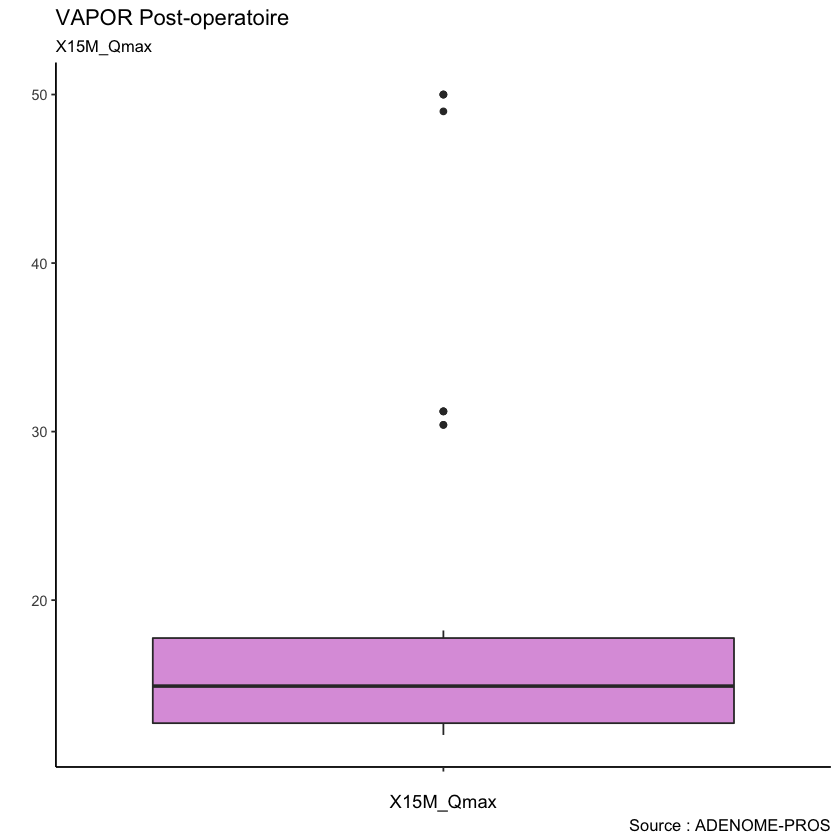

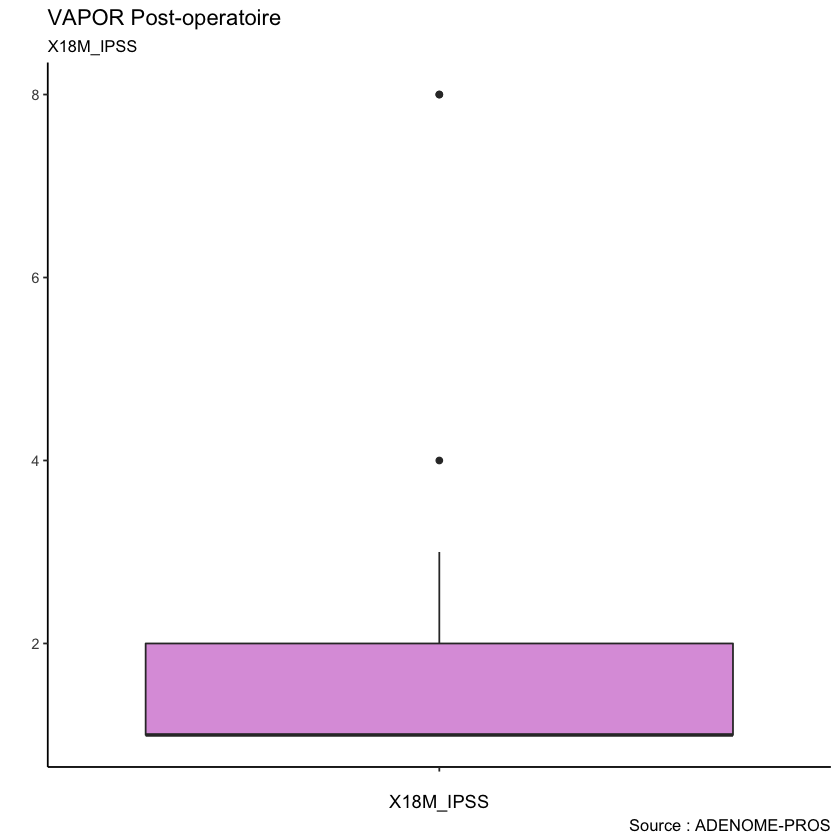

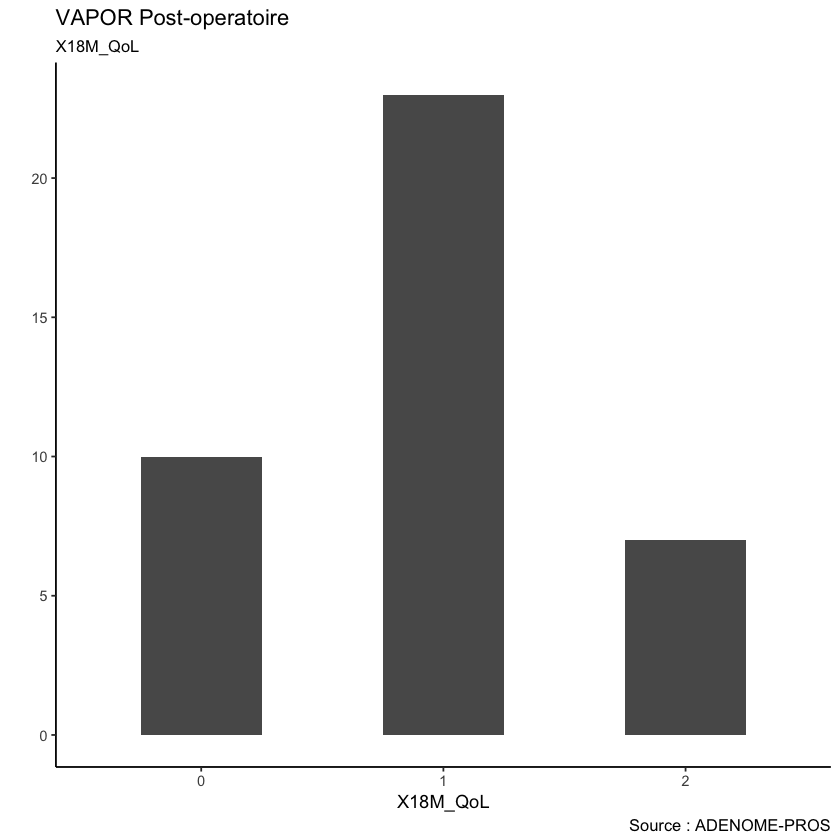

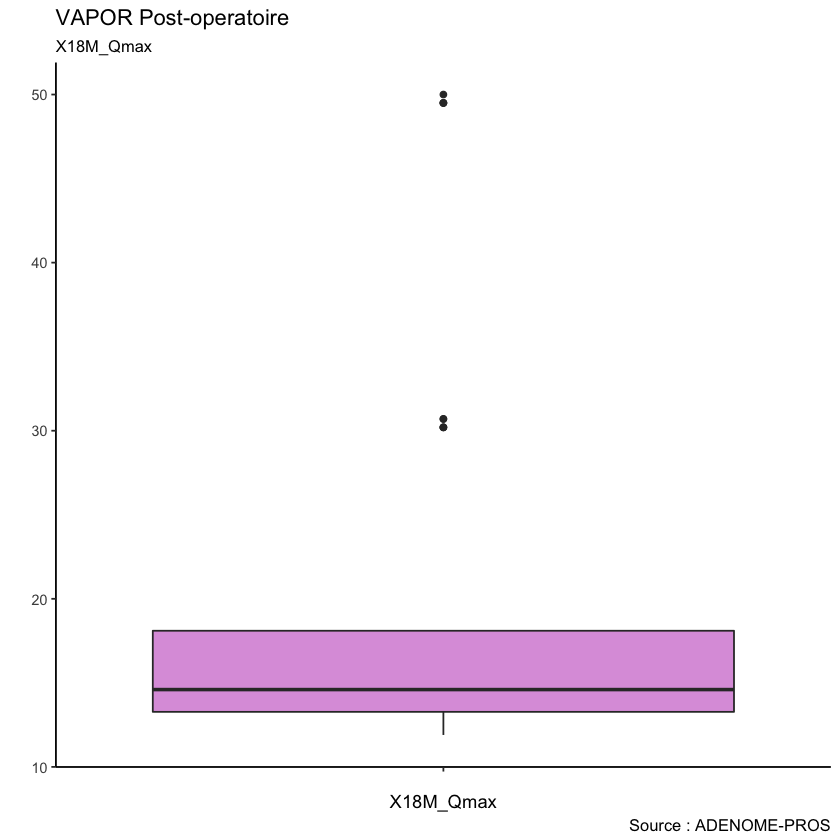

In [15]:
# Boxplots des variables numériques et barplots des variables catégoriques

for (i in 1:ncol(vapor_post)) {
  #x11(display="")
  if (is.numeric(vapor_post[,i]) || is.integer(vapor_post[,i])) {
    adenome_boxplot(vapor_post,i,"VAPOR Post-operatoire")
  }
  else
    adenome_barplot(vapor_post,i,"VAPOR Post-operatoire")
}

### 1.2.2 Corrélations entre les variables post-opératoire

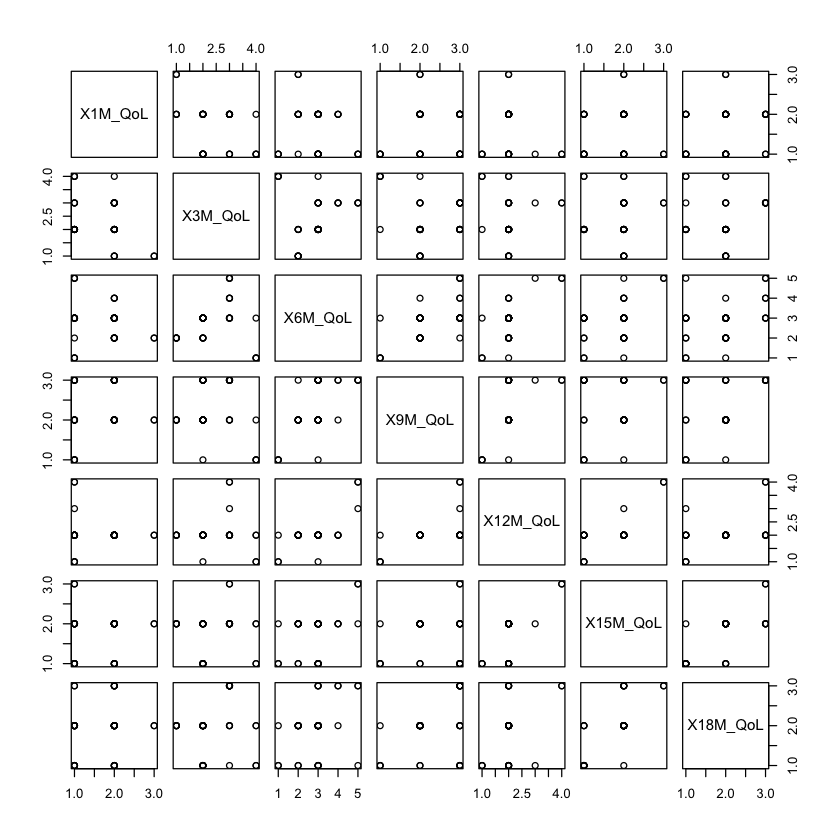

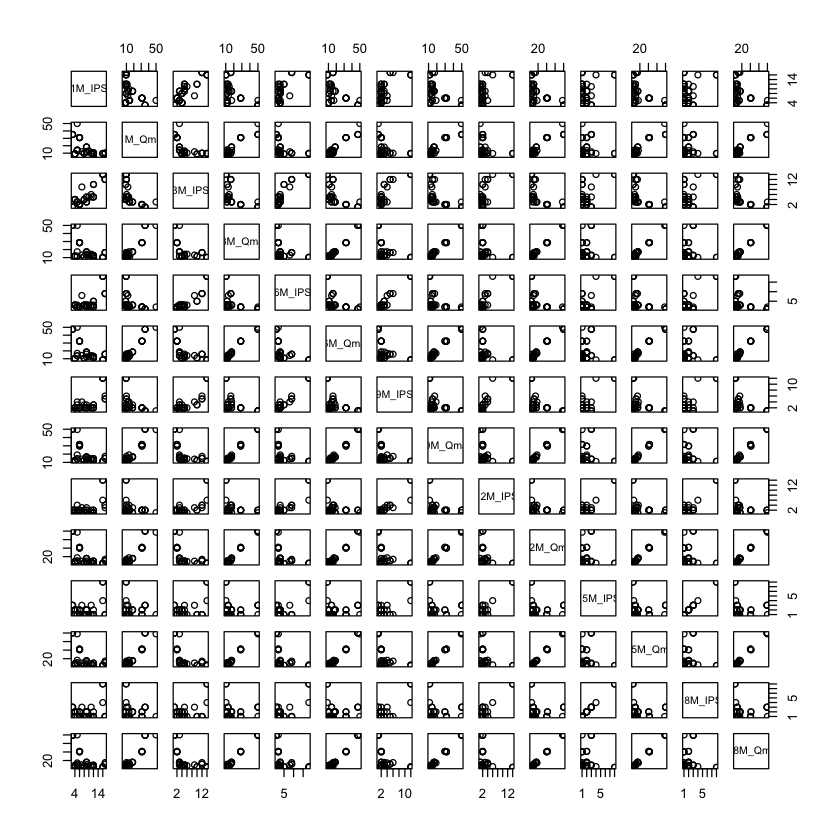

In [16]:
plot(vapor_cat_post)
plot(vapor_num_post)